<a href="https://colab.research.google.com/github/cdarbelaez/SolarForecastingElecEngUdeA/blob/main/DATABASES/Transformer_n3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TRANSFORMER NN (UNIVARIABLE MINMAX)**

---


> En este notebook se realiza la implementación de la red neuronal mencionada: 

*   Se parte del preprocesamiento y análisis de los datos que **NO** está incluido en este script.
*   Luego se procede a cargar y escalar el dataset previamente procesado.
*   Se preparan en ventanas y se separan en set de entrenamiento y validación.
*   Luego se implementa el modelo de aprendizaje automatico con una arquitectura e hiperparametros previamente establecidos.
*   Por último se validan los resultados y se obtienen las métricas de error.

---

**BASE DE DATOS:** KENYA



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug  9 02:24:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   2856MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


---
# 1.   **SE IMPORTAN LAS BIBLIOTECAS NECESARIAS**

---



  Importamos las librerias necesarias para todo el script: 

1.   **Matplotlib** para realizar las gráficas
2.   **Pandas** para procesar la base de datos
3.   **Numpy** para convertir la base de datos en arreglos numéricos
4.   **Os** para acceder a los archivos mediante rutas de almacenamiento
5.   **Seaborn** para realizar análisis gráficos a los datos mediante análisis estadisticos
6.   **Drive** se utiliza para acceder a las carpetas de datos del drive de un correo asociado
7.   **Tensorflow** es la librería mediante la cual se generan los modelos de redes neuronales



In [ ]:
import keras
import keras
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.callbacks import Callback
#from kerastuner.tuners import RandomSearch

from sklearn.metrics import r2_score


#from utils import rmse, coeff_determination, smape
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from google.colab import drive 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6) #Definimos el tamaño para las figuras de matplotlib
mpl.rcParams['axes.grid'] = False

---


# 1.1   **SE DEFINEN OBJETOS Y FUNCIONES DE MÉTRICAS**

---

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import keras.backend as K

#--------------------------------------------------------
# Función para calcular el mape
#--------------------------------------------------------
def mape(y_true, y_pred):
    import keras.backend as K
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

#--------------------------------------------------------
# Función para calcular el Symetric Mape
#--------------------------------------------------------
def smape(y_true, y_pred):
    import keras.backend as K
    return 100*K.mean(K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))), axis=-1)

#--------------------------------------------------------
#Función para calcular el RMSE
#--------------------------------------------------------
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

#--------------------------------------------------------
#Funcion para calcular el MAE
#--------------------------------------------------------
def mae(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

#--------------------------------------------------------
#Función para calcular el Symetric MAE
#--------------------------------------------------------
def mase(y_true, y_pred):
    sust = K.mean(K.abs(y_true[:,1:] - y_true[:,:-1]))
    diff = K.mean(K.abs(y_pred - y_true))
    return diff/sust

#--------------------------------------------------------
#Función para calcular el coeficiente de determinación
#--------------------------------------------------------
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )



In [ ]:
class Transformer(object):
    #----------------------------------------------------------------------------------
    # Construcción de la red neuronal recurrente para el pronostico de series de tiempo
    #----------------------------------------------------------------------------------
    def __init__(self):

        """ Inicialización del objeto
        """
        #--------------------------------------------------------
        # Se definen los parametros del modelo
        #--------------------------------------------------------
        self.look_back = 96 # Número de datos pasados
        self.n_features = 1 # Número de variables a utilizar
        self.horizon = 96   # Horizonte de pronostico
        self.batch_size =1  # Tamaño del lote utilizado de entrenamiento

        #--------------------------------------------------------
        # Se define la dirección donde se guardan los progresos del entrenamiento
        #--------------------------------------------------------
        self.log_dir = 'log'  # Definimos el nombre de la carpeta
        self.checkpoint_dir = 'checkpoint' # Dirección del archivo

        #--------------------------------------------------------
        # Se definen hiperparametros del modelo
        #--------------------------------------------------------
        self.head_size=256
        self.num_heads=4
        self.ff_dim=4
        self.num_transformer_blocks=4 # Número de bloques de redes neuronales
        self.mlp_units=[192] # Número de neuronas por cada red neuronal perceptrón
        self.mlp_dropout=0.4 # Dropout de cada neurona
        self.dropout=0.25 # Dropout para el modelo completo

    #----------------------------------------------------------------------------------
    #Definimos el codificador del modelo
    #----------------------------------------------------------------------------------
    def transformer_encoder(self,inputs):

        # Normalización y Multihead Attention
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)
        x = layers.MultiHeadAttention(
        key_dim=self.head_size, num_heads=self.num_heads, dropout=self.dropout)(x, x)
        x = layers.Dropout(self.dropout)(x)

        res = x + inputs

        # Feed Forward Part
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=self.ff_dim, kernel_size=1, activation="relu")(x)
        x = layers.Dropout(self.dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        return x + res

    #-----------------------------------------------------------------------------------
    #Definimos el método e construcción de la red neuronal
    #-----------------------------------------------------------------------------------
    def build(self):
        """ Definimos la arquitectura del modelo 
        """

        inputs = keras.Input(shape=(self.look_back, self.n_features))
        #inputs = keras.Input((self.batch_size, x_train1.shape[1], x_train1.shape[2]))
        x = inputs
        for _ in range(self.num_transformer_blocks):
            x = self.transformer_encoder(x)

        x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
        for dim in self.mlp_units:
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.Dropout(self.mlp_dropout)(x)

        # output layer
        outputs = layers.Dense(self.horizon)(x)

        return keras.Model(inputs, outputs)

    #-----------------------------------------------------------------------------------------
    # Se define el método de la clase encargado de guardar los checkpoints en el entrenamiento
    #-----------------------------------------------------------------------------------------
    def restore(self,
        filepath):
        """ Almacenamos el modelo previamente entrenado
        """

        # Load the architecture
        self.best_model = load_model(filepath, custom_objects={'smape': smape,
                                                         #'mape': mape,
                                                         'rmse' : rmse,
                                                         'coeff_determination' : coeff_determination})

        ## added cause with TF 2.4, custom metrics are not recognize custom metrics with only load-model
        self.best_model.compile(
            optimizer='adam',
            loss = ['mae'],
            metrics=[rmse, 'mae', smape, coeff_determination])

    #-----------------------------------------------------------------------------------
    # Definimos el método de la clase encargado de realizar el entrenamiento del modelo
    #-----------------------------------------------------------------------------------
    def train(self, X_train, y_train, epochs=200, batch_size=1):

        """ Training the network
        :param X_train: training feature vectors [#batch,#number_of_timesteps,#number_of_features]
        :type 3-D Numpy array of float values
        :param Y_train: training target vectors
        :type 2-D Numpy array of float values
        :param epochs: number of training epochs
        :type int
        :param batch_size: size of batches used at each forward/backward propagation
        :type int
        :return -
        :raises: -
        """

        self.model = self.build()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss = ['mse'],
                           metrics=[rmse, 'mae', smape, coeff_determination],
                           )
        print(self.model.summary())

        # Stop training if error does not improve within 50 iterations
        early_stopping_monitor = EarlyStopping(patience=50, restore_best_weights=True)

        # Save the best model ... with minimal error
        filepath = self.checkpoint_dir+"/Transformer.best"#+datetime.now().strftime('%d%m%Y_%H:%M:%S')+".hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

        callback_history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                             #validation_split=0.2,
                             verbose=1,
                             callbacks=[early_stopping_monitor, checkpoint])
                             #callbacks=[PlotLossesKeras(), early_stopping_monitor, checkpoint])
        self.history = callback_history.history
        return callback_history

    #----------------------------------------------------------------------------------------
    # Definimos un método encargado de evaluar el desempeño del modelo
    #----------------------------------------------------------------------------------------
    def evaluate(self, X_test, y_test):

        """ Evaluating the network
        :param X_test: test feature vectors [#batch,#number_of_timesteps,#number_of_features]
        :type 3-D Numpy array of float values
        :param Y_test: test target vectors
        :type 2-D Numpy array of int values
        :return  Evaluation losses
        :rtype 5 Float tuple
        :raise -
        """

        y_pred = self.model.predict(X_test)

        # Print accuracy if ground truth is provided
        """
        if y_test is not None:
            loss_ = session.run(
                self.loss,
                feed_dict=feed_dict)
        """

        _, rmse_result, mae_result, smape_result, _ = self.model.evaluate(X_test, y_test)

        #r2_result = r2_score(y_test.flatten(),y_pred.flatten())

        return _, rmse_result, mae_result, smape_result#, r2_result
    
    #----------------------------------------------------------------------------------------------------
    # Definimos el método de la clase encargado de realizar los pronosticos luego de entrenado el modelo
    #----------------------------------------------------------------------------------------------------
    def predict(self, x):

        y_pred = self.model.predict(x)
        return y_pred



---


# 2.   **SE CARGA EL DATASET PREVIAMENTE PROCESADO**

---




En la siguiente celda de codigo se llama una función de google colab mediante la cual se accede a la carpeta de drive, luego se define la ruta de acceso a la base de datos previamente procesados para la realización del modelo y se procesa mediante la librería `Pandas`:

In [ ]:
#ruta= 'https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv'
ruta='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/KENYA_LIMPIO.csv'
data = pd.read_csv(ruta,encoding='utf-8') # Se hace la respectiva lectura, no se añade encabezado o indice, por lo que pondrá por defecto la numeracion
if ruta=='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv':
  data.set_index('datetime', inplace=True)
else:
  data.set_index('time', inplace=True) # Establecemos cual será el indice del dataframe
data.head(2) # Se muestran las 5 primeras filas del dataframe

,dhi_pyr,ghi_pyr_1,ghi_pyr_2,air_temperature,relative_humidity,barometric_pressure,precipitation,wind_speed,wind_from_direction,gti_clean,gti_soil,gti_monthly,sensor_cleaning,Hour
time,,,,,,,,,,,,,,
2019-12-12 00:00:00,0.0,0.0,0.0,22.72500,99.003998,948.445923,0.0,1.073283,169.845993,0.0,0.0,0.0,0.0,0
2019-12-12 00:15:00,0.0,0.0,0.0,22.58083,98.758003,948.415283,0.0,0.727417,204.165405,0.0,0.0,0.0,0.0,0




---


# 3. **SE SELECCIONAN LOS DATOS A UTILIZAR PARA EL ENTRENAMIENTO DEL MODELO**


---



Luego de analizar las corelaciones, se llego a la conclusion de que los datos que más influencia tienen sobre los valores de irradianza `GHI` son los que se seleccionaron y se colocaron en un nuevo dataset:



In [ ]:
if ruta=='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv':
  features_considered = ['GHI']# Definimos las columnas que se van a utilizar para el entrenamiento del modelo
  features = data[features_considered].loc['2010-04-07 00:00:00':] # Creamos un dataframe con solo estos datos
else:
  features_considered = ['ghi_pyr_1']#,'relative_humidity']
  features = data[features_considered] # Creamos un dataframe con solo estos datos
features.head() #Se muestran los 5 primeros datos

,ghi_pyr_1
time,
2019-12-12 00:00:00,0.0
2019-12-12 00:15:00,0.0
2019-12-12 00:30:00,0.0
2019-12-12 00:45:00,0.0
2019-12-12 01:00:00,0.0


Graficamos todos los datos con el fin de apreciar de manera general su comportamiento a lo largo del tiempo con la función plot asociada a la librería `Pandas`.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f94eae14b90>],
      dtype=object)

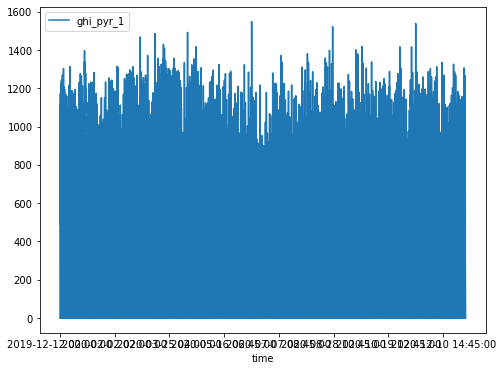

In [ ]:
features.plot(subplots=True) # Graficamos las columnas de datos para observar su comportamiento

Se convierte el conjunto de datos en un arreglo de `numpy` definiendo la cantidad de datos que se van a utilizar para el proceso y luego se estandarizan con una normalización:


In [ ]:
TRAIN_SPLIT = int(len(features)*0.8//1) #Definimos la cantidad de datos que se van a usar para el entrenamiento del modelo
dataset = features.values # Convertimos el dataframe en un arreglo de numpy



---


3_1. **ESCALAMIENTO DE LOS DATOS**


---


In [ ]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)




---


# 4.   **SE DEFINE LA FUNCIÓN QUE SE UTILIZA PARA LA PARTICIÓN DE LOS DATOS EN VENTANAS MOVILES**

--- 

In [ ]:
#---------------------------------------
#CONFIGURACIÓN DE LAS VENTANAS DE DATOS#
#---------------------------------------
DATASPLIT = 0.8                        #
Num_datos_entrada = 96                 #
Num_datos_salida = 96                  #
#---------------------------------------

def ventanas(dataset,xsize,ysize,split,validation= False):
  #dataset: Es un array de numpy obtenido a partir del dataframe de pandas, en este están contenidos todos los datos que se utilizarán
  #split: porcentaje del dataset a utilizar
  #xsize: Número entero, determina el tamaño de la ventana de caracteristicas (Entradas del modelo)
  #ysize: Número entero, determina el tamaño de la ventana de etiquetas (Salidas del modelo)
  #validation: Si es True, toma el porcentaje restante de los datos como set, de lo contrario toma el porcentaje indicado

  if validation!=True: #Se generan los índices para tomar los días exactos para el set de entrenamiento
    indexin=int(0)
    indexf=int((((len(dataset)*split)//xsize)*xsize))
  else: #Se generan los índices para tomar los días exactos para el set de validación
    indexin=int((((len(dataset)*split)//xsize)*xsize))
    indexf=int(len(dataset))
  n=0 # Indexador
  x=[] # Lista vacia donde estarán contenidas las ventanas de datos de entrada (Caracteristicas)
  y=[] # Lista vacia donde estarán contenidas las ventanas de datos de salida (Etiquetas)
  
  for i in range(int(((indexf-indexin)/ysize)-2)): #Este ciclo se repite el número de veces como ventanas habrán en un arreglo de datos
                                                   # Ejemplo: dataset= [1,2,3,4,5,6]
                                                   # indexf=6, indexin=0, xsize=2, ysize=2
                                                   # range= (3-1) = 2  <------ Ya que se obtendrán 3 ventanas de datos
                                                   # Al resultado se le resta uno para considerar que la ultima ventana tambien contenga datos en "y"
                                                   
    x.append(dataset[n+indexin:n+indexin+xsize]) #Se agrega a la lista la ventana de datos utilizando la idexación 
                                                   # Ejemplo: dataset= [1,2,3,4,5,6]
                                                   # Primera iteración:
                                                   #  x=[[1,2]]
                                                   # Segunda iteración:
                                                   #  x=[[1,2],[3,4]]

    y.append(dataset[n+indexin+xsize:n+indexin+xsize+ysize])
                                                   # Siguiendo el ejemplo anterior
                                                   #  y=[[3,4]]
                                                   # Segunda iteración:
                                                   #  y=[[3,4],[5,6]]
    
                                                   # Siguiento el ejemplo, los las ventanas listas para entrar al modelo quedan de la siguiente manera
                                                   # x = [[1,2],[3,4]]
                                                   # y = [[3,4],[5,6]]

    n+=ysize # Se suma al indexador el tamaño de la ventana
    
  return np.array(x),np.array(y)

x_train1, y_train1= ventanas(dataset, xsize= Num_datos_entrada, ysize= Num_datos_salida, split = DATASPLIT)
x_val1,y_val1=ventanas(dataset, xsize= Num_datos_entrada, ysize= Num_datos_salida, split = DATASPLIT, validation=True)

In [ ]:
x_train1.shape

(306, 96, 1)



---


# 5.   **FUNCIÓN PARA VISUALIZAR LOS RESULTADOS OBTENIDOS**


---



La siguiente de función se utiliza para generar gráficos a partir de una ventana de tiempo como las que se definieron anteriormente, esta se utilizará para mostrar:

*   La ventana de tiempo utilizada para la predicción
*   El valor real de los datos futuros tomado del set de validación
*   El valor de las predicciones que arroja la red neuronal



In [ ]:
def create_time_steps(length): # Función que crea un array en un rango determinado por el tamaño de la ventana de datos
    return list(range(-length, 0))

# history: Un arreglo con la ventana de datos usada para la predicción
# true_future: Arreglo con los datos conocidos que deberia arrojar la predicción 
# prediction: Arreglo con las predicciones obtenidas

def multi_step_plot(history, true_future, prediction): 
    plt.figure(figsize=(12, 6)) # Se define el tamaño de la figura
    num_in = create_time_steps(len(history)) #Tamaño de la curva de datos pasados
    num_out = len(true_future) # Tamaño de la curva de datos futuros
    plt.plot(num_in, history, label='History') # Graficamos datos pasados
    plt.plot(np.arange(num_out)/STEP, (true_future), 'y--',
           label='True Future') #Graficamos datos furutos
    if prediction.any(): # Si se ingresan datos sobre las predicciones
        plt.plot(np.arange(num_out)/STEP, (prediction), 'r--', #Grafica tambien las predicciones
                 label='Predicted Future')
    plt.legend(loc='upper left') # Ajustes de la grafica
    plt.grid()
    plt.show() # Se muestra la grafica

---
 # 6. **CREACIÓN Y ENTRENAMIENTO DEL MODELO**

---

In [ ]:
look_back = 96
n_features = data.shape[1]

# Walk-forward data split to avoid data leakage

# reshape input to be 3D [samples, timesteps, features]
x_train_reshaped = x_train1
x_test_reshaped = x_val1

y_train_reshaped = y_train1
y_test_reshaped = y_val1

## Testing the RNN-LSTM
"""
rnn = RNN()
rnn.train(X_train_reshaped,y_train_reshaped)
_, rmse_result, mae_result, smape_result, r2_result = rnn.evaluate(X_test_reshaped,y_test_reshaped)"""

## Testing the Transformer
tr = Transformer()
tr.train(x_train_reshaped,y_train_reshaped)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 1)]      0           []                               
                                                                                                  
 layer_normalization_60 (LayerN  (None, 96, 1)       2           ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_30 (Multi  (None, 96, 1)       32257       ['layer_normalization_60[0][0]', 
 HeadAttention)                                                   'layer_normalization_60[0][0]'] 
                                                                                            


Epoch 1: loss improved from inf to 0.07543, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 30s 74ms/step - loss: 0.0754 - rmse: 0.2651 - mae: 0.2006 - smape: 75.8969 - coeff_determination: -0.1127
Epoch 2/200
305/306 [============================>.] - ETA: 0s - loss: 0.0247 - rmse: 0.1544 - mae: 0.1208 - smape: 64.5489 - coeff_determination: 0.6017WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 2: loss improved from 0.07543 to 0.02471, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 72ms/step - loss: 0.0247 - rmse: 0.1543 - mae: 0.1208 - smape: 64.5437 - coeff_determination: 0.6021
Epoch 3/200
305/306 [============================>.] - ETA: 0s - loss: 0.0186 - rmse: 0.1332 - mae: 0.1043 - smape: 62.9341 - coeff_determination: 0.6886WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 3: loss improved from 0.02471 to 0.01855, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 75ms/step - loss: 0.0185 - rmse: 0.1331 - mae: 0.1042 - smape: 62.9268 - coeff_determination: 0.6889
Epoch 4/200
306/306 [==============================] - ETA: 0s - loss: 0.0158 - rmse: 0.1219 - mae: 0.0949 - smape: 61.9576 - coeff_determination: 0.7200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 4: loss improved from 0.01855 to 0.01576, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 75ms/step - loss: 0.0158 - rmse: 0.1219 - mae: 0.0949 - smape: 61.9576 - coeff_determination: 0.7200
Epoch 5/200
305/306 [============================>.] - ETA: 0s - loss: 0.0145 - rmse: 0.1164 - mae: 0.0900 - smape: 61.6514 - coeff_determination: 0.7407WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 5: loss improved from 0.01576 to 0.01448, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0145 - rmse: 0.1164 - mae: 0.0900 - smape: 61.6466 - coeff_determination: 0.7410
Epoch 6/200
306/306 [==============================] - ETA: 0s - loss: 0.0128 - rmse: 0.1092 - mae: 0.0839 - smape: 61.0608 - coeff_determination: 0.7719WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 6: loss improved from 0.01448 to 0.01279, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0128 - rmse: 0.1092 - mae: 0.0839 - smape: 61.0608 - coeff_determination: 0.7719
Epoch 7/200
306/306 [==============================] - ETA: 0s - loss: 0.0120 - rmse: 0.1053 - mae: 0.0801 - smape: 60.5549 - coeff_determination: 0.7840WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 7: loss improved from 0.01279 to 0.01197, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 76ms/step - loss: 0.0120 - rmse: 0.1053 - mae: 0.0801 - smape: 60.5549 - coeff_determination: 0.7840
Epoch 8/200
306/306 [==============================] - ETA: 0s - loss: 0.0109 - rmse: 0.0999 - mae: 0.0756 - smape: 60.3472 - coeff_determination: 0.7905WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 8: loss improved from 0.01197 to 0.01091, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 24s 78ms/step - loss: 0.0109 - rmse: 0.0999 - mae: 0.0756 - smape: 60.3472 - coeff_determination: 0.7905
Epoch 9/200
305/306 [============================>.] - ETA: 0s - loss: 0.0108 - rmse: 0.0991 - mae: 0.0744 - smape: 60.1530 - coeff_determination: 0.7908WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 9: loss improved from 0.01091 to 0.01086, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 72ms/step - loss: 0.0109 - rmse: 0.0992 - mae: 0.0744 - smape: 60.1623 - coeff_determination: 0.7908
Epoch 10/200
305/306 [============================>.] - ETA: 0s - loss: 0.0098 - rmse: 0.0946 - mae: 0.0708 - smape: 59.7384 - coeff_determination: 0.8166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 10: loss improved from 0.01086 to 0.00978, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0098 - rmse: 0.0945 - mae: 0.0708 - smape: 59.7339 - coeff_determination: 0.8170
Epoch 11/200
305/306 [============================>.] - ETA: 0s - loss: 0.0091 - rmse: 0.0907 - mae: 0.0675 - smape: 59.3467 - coeff_determination: 0.8241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 11: loss improved from 0.00978 to 0.00917, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 24s 79ms/step - loss: 0.0092 - rmse: 0.0909 - mae: 0.0677 - smape: 59.3578 - coeff_determination: 0.8240
Epoch 12/200
306/306 [==============================] - ETA: 0s - loss: 0.0091 - rmse: 0.0904 - mae: 0.0670 - smape: 59.3844 - coeff_determination: 0.8212WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 12: loss improved from 0.00917 to 0.00912, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0091 - rmse: 0.0904 - mae: 0.0670 - smape: 59.3844 - coeff_determination: 0.8212
Epoch 13/200
306/306 [==============================] - ETA: 0s - loss: 0.0087 - rmse: 0.0879 - mae: 0.0646 - smape: 59.0091 - coeff_determination: 0.8306WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 13: loss improved from 0.00912 to 0.00866, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0087 - rmse: 0.0879 - mae: 0.0646 - smape: 59.0091 - coeff_determination: 0.8306
Epoch 14/200
305/306 [============================>.] - ETA: 0s - loss: 0.0085 - rmse: 0.0866 - mae: 0.0632 - smape: 59.0577 - coeff_determination: 0.8283WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 14: loss improved from 0.00866 to 0.00848, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0085 - rmse: 0.0866 - mae: 0.0632 - smape: 59.0552 - coeff_determination: 0.8285
Epoch 15/200
305/306 [============================>.] - ETA: 0s - loss: 0.0078 - rmse: 0.0832 - mae: 0.0606 - smape: 58.7971 - coeff_determination: 0.8475WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 15: loss improved from 0.00848 to 0.00783, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0078 - rmse: 0.0832 - mae: 0.0607 - smape: 58.8032 - coeff_determination: 0.8475
Epoch 16/200
306/306 [==============================] - ETA: 0s - loss: 0.0079 - rmse: 0.0836 - mae: 0.0607 - smape: 58.7994 - coeff_determination: 0.8365WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 16: loss did not improve from 0.00783
306/306 [==============================] - 8s 27ms/step - loss: 0.0079 - rmse: 0.0836 - mae: 0.0607 - smape: 58.7994 - coeff_determination: 0.8365
Epoch 17/200
306/306 [==============================] - ETA: 0s - loss: 0.0078 - rmse: 0.0828 - mae: 0.0594 - smape: 58.6202 - coeff_determination: 0.8385WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 17: loss did not improve from 0.00783
306/306 [==============================] - 8s 28ms/step - loss: 0.0078 - rmse: 0.0828 - mae: 0.0594 - smape: 58.6202 - coeff_determination: 0.8385
Epoch 18/200
306/306 [==============================] - ETA: 0s - loss: 0.0075 - rmse: 0.0802 - mae: 0.0574 - smape: 58.4920 - coeff_determination: 0.8527WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 18: loss improved from 0.00783 to 0.00745, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0075 - rmse: 0.0802 - mae: 0.0574 - smape: 58.4920 - coeff_determination: 0.8527
Epoch 19/200
305/306 [============================>.] - ETA: 0s - loss: 0.0072 - rmse: 0.0798 - mae: 0.0567 - smape: 58.3806 - coeff_determination: 0.8555WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 19: loss improved from 0.00745 to 0.00723, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0072 - rmse: 0.0798 - mae: 0.0567 - smape: 58.3771 - coeff_determination: 0.8557
Epoch 20/200
306/306 [==============================] - ETA: 0s - loss: 0.0072 - rmse: 0.0788 - mae: 0.0558 - smape: 58.2158 - coeff_determination: 0.8533WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 20: loss improved from 0.00723 to 0.00717, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0072 - rmse: 0.0788 - mae: 0.0558 - smape: 58.2158 - coeff_determination: 0.8533
Epoch 21/200
305/306 [============================>.] - ETA: 0s - loss: 0.0071 - rmse: 0.0782 - mae: 0.0550 - smape: 58.1596 - coeff_determination: 0.8583WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 21: loss improved from 0.00717 to 0.00709, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0071 - rmse: 0.0781 - mae: 0.0550 - smape: 58.1557 - coeff_determination: 0.8586
Epoch 22/200
306/306 [==============================] - ETA: 0s - loss: 0.0068 - rmse: 0.0761 - mae: 0.0533 - smape: 57.9311 - coeff_determination: 0.8625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 22: loss improved from 0.00709 to 0.00678, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 76ms/step - loss: 0.0068 - rmse: 0.0761 - mae: 0.0533 - smape: 57.9311 - coeff_determination: 0.8625
Epoch 23/200
305/306 [============================>.] - ETA: 0s - loss: 0.0070 - rmse: 0.0773 - mae: 0.0540 - smape: 58.0624 - coeff_determination: 0.8627WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 23: loss did not improve from 0.00678
306/306 [==============================] - 8s 27ms/step - loss: 0.0070 - rmse: 0.0772 - mae: 0.0539 - smape: 58.0511 - coeff_determination: 0.8631
Epoch 24/200
306/306 [==============================] - ETA: 0s - loss: 0.0067 - rmse: 0.0755 - mae: 0.0526 - smape: 57.9503 - coeff_determination: 0.8620WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 24: loss improved from 0.00678 to 0.00674, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0067 - rmse: 0.0755 - mae: 0.0526 - smape: 57.9503 - coeff_determination: 0.8620
Epoch 25/200
306/306 [==============================] - ETA: 0s - loss: 0.0066 - rmse: 0.0749 - mae: 0.0513 - smape: 57.8285 - coeff_determination: 0.8662WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 25: loss improved from 0.00674 to 0.00658, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0066 - rmse: 0.0749 - mae: 0.0513 - smape: 57.8285 - coeff_determination: 0.8662
Epoch 26/200
305/306 [============================>.] - ETA: 0s - loss: 0.0064 - rmse: 0.0735 - mae: 0.0505 - smape: 57.7104 - coeff_determination: 0.8721WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 26: loss improved from 0.00658 to 0.00641, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0064 - rmse: 0.0737 - mae: 0.0506 - smape: 57.7321 - coeff_determination: 0.8718
Epoch 27/200
306/306 [==============================] - ETA: 0s - loss: 0.0064 - rmse: 0.0734 - mae: 0.0502 - smape: 57.6596 - coeff_determination: 0.8683WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 27: loss improved from 0.00641 to 0.00640, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 76ms/step - loss: 0.0064 - rmse: 0.0734 - mae: 0.0502 - smape: 57.6596 - coeff_determination: 0.8683
Epoch 28/200
306/306 [==============================] - ETA: 0s - loss: 0.0063 - rmse: 0.0727 - mae: 0.0493 - smape: 57.6119 - coeff_determination: 0.8721WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 28: loss improved from 0.00640 to 0.00628, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 74ms/step - loss: 0.0063 - rmse: 0.0727 - mae: 0.0493 - smape: 57.6119 - coeff_determination: 0.8721
Epoch 29/200
306/306 [==============================] - ETA: 0s - loss: 0.0063 - rmse: 0.0725 - mae: 0.0489 - smape: 57.4612 - coeff_determination: 0.8687WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 29: loss improved from 0.00628 to 0.00627, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0063 - rmse: 0.0725 - mae: 0.0489 - smape: 57.4612 - coeff_determination: 0.8687
Epoch 30/200
306/306 [==============================] - ETA: 0s - loss: 0.0062 - rmse: 0.0721 - mae: 0.0483 - smape: 57.3729 - coeff_determination: 0.8775WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 30: loss improved from 0.00627 to 0.00617, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0062 - rmse: 0.0721 - mae: 0.0483 - smape: 57.3729 - coeff_determination: 0.8775
Epoch 31/200
306/306 [==============================] - ETA: 0s - loss: 0.0062 - rmse: 0.0721 - mae: 0.0480 - smape: 57.5336 - coeff_determination: 0.8743WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 31: loss did not improve from 0.00617
306/306 [==============================] - 8s 27ms/step - loss: 0.0062 - rmse: 0.0721 - mae: 0.0480 - smape: 57.5336 - coeff_determination: 0.8743
Epoch 32/200
306/306 [==============================] - ETA: 0s - loss: 0.0061 - rmse: 0.0710 - mae: 0.0472 - smape: 57.3996 - coeff_determination: 0.8740WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 32: loss improved from 0.00617 to 0.00609, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 76ms/step - loss: 0.0061 - rmse: 0.0710 - mae: 0.0472 - smape: 57.3996 - coeff_determination: 0.8740
Epoch 33/200
305/306 [============================>.] - ETA: 0s - loss: 0.0058 - rmse: 0.0694 - mae: 0.0459 - smape: 57.2856 - coeff_determination: 0.8860WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 33: loss improved from 0.00609 to 0.00583, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0058 - rmse: 0.0696 - mae: 0.0460 - smape: 57.3186 - coeff_determination: 0.8856
Epoch 34/200
305/306 [============================>.] - ETA: 0s - loss: 0.0058 - rmse: 0.0697 - mae: 0.0456 - smape: 57.1255 - coeff_determination: 0.8830WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 34: loss improved from 0.00583 to 0.00579, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0058 - rmse: 0.0697 - mae: 0.0456 - smape: 57.1265 - coeff_determination: 0.8830
Epoch 35/200
305/306 [============================>.] - ETA: 0s - loss: 0.0058 - rmse: 0.0694 - mae: 0.0454 - smape: 57.1150 - coeff_determination: 0.8836WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 35: loss did not improve from 0.00579
306/306 [==============================] - 9s 28ms/step - loss: 0.0058 - rmse: 0.0696 - mae: 0.0455 - smape: 57.1270 - coeff_determination: 0.8833
Epoch 36/200
305/306 [============================>.] - ETA: 0s - loss: 0.0058 - rmse: 0.0694 - mae: 0.0450 - smape: 57.0927 - coeff_determination: 0.8791WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 36: loss did not improve from 0.00579
306/306 [==============================] - 8s 27ms/step - loss: 0.0058 - rmse: 0.0696 - mae: 0.0451 - smape: 57.1076 - coeff_determination: 0.8786
Epoch 37/200
305/306 [============================>.] - ETA: 0s - loss: 0.0058 - rmse: 0.0697 - mae: 0.0450 - smape: 57.0786 - coeff_determination: 0.8853WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 37: loss did not improve from 0.00579
306/306 [==============================] - 8s 27ms/step - loss: 0.0058 - rmse: 0.0696 - mae: 0.0450 - smape: 57.0866 - coeff_determination: 0.8856
Epoch 38/200
306/306 [==============================] - ETA: 0s - loss: 0.0057 - rmse: 0.0687 - mae: 0.0441 - smape: 57.0354 - coeff_determination: 0.8840WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 38: loss improved from 0.00579 to 0.00572, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 76ms/step - loss: 0.0057 - rmse: 0.0687 - mae: 0.0441 - smape: 57.0354 - coeff_determination: 0.8840
Epoch 39/200
306/306 [==============================] - ETA: 0s - loss: 0.0059 - rmse: 0.0695 - mae: 0.0443 - smape: 57.0026 - coeff_determination: 0.8807WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 39: loss did not improve from 0.00572
306/306 [==============================] - 8s 27ms/step - loss: 0.0059 - rmse: 0.0695 - mae: 0.0443 - smape: 57.0026 - coeff_determination: 0.8807
Epoch 40/200
305/306 [============================>.] - ETA: 0s - loss: 0.0058 - rmse: 0.0696 - mae: 0.0440 - smape: 57.0145 - coeff_determination: 0.8851WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 40: loss did not improve from 0.00572
306/306 [==============================] - 8s 27ms/step - loss: 0.0058 - rmse: 0.0695 - mae: 0.0439 - smape: 56.9990 - coeff_determination: 0.8854
Epoch 41/200
305/306 [============================>.] - ETA: 0s - loss: 0.0057 - rmse: 0.0683 - mae: 0.0432 - smape: 56.9401 - coeff_determination: 0.8914WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 41: loss improved from 0.00572 to 0.00564, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0056 - rmse: 0.0683 - mae: 0.0432 - smape: 56.9395 - coeff_determination: 0.8916
Epoch 42/200
305/306 [============================>.] - ETA: 0s - loss: 0.0055 - rmse: 0.0673 - mae: 0.0421 - smape: 56.7703 - coeff_determination: 0.8905WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 42: loss improved from 0.00564 to 0.00548, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 74ms/step - loss: 0.0055 - rmse: 0.0672 - mae: 0.0421 - smape: 56.7636 - coeff_determination: 0.8907
Epoch 43/200
306/306 [==============================] - ETA: 0s - loss: 0.0054 - rmse: 0.0673 - mae: 0.0419 - smape: 56.7604 - coeff_determination: 0.8962WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 43: loss improved from 0.00548 to 0.00539, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 74ms/step - loss: 0.0054 - rmse: 0.0673 - mae: 0.0419 - smape: 56.7604 - coeff_determination: 0.8962
Epoch 44/200
305/306 [============================>.] - ETA: 0s - loss: 0.0055 - rmse: 0.0672 - mae: 0.0417 - smape: 56.6963 - coeff_determination: 0.8921WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 44: loss did not improve from 0.00539
306/306 [==============================] - 9s 29ms/step - loss: 0.0055 - rmse: 0.0672 - mae: 0.0417 - smape: 56.6906 - coeff_determination: 0.8924
Epoch 45/200
306/306 [==============================] - ETA: 0s - loss: 0.0054 - rmse: 0.0659 - mae: 0.0405 - smape: 56.5279 - coeff_determination: 0.8904WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 45: loss improved from 0.00539 to 0.00537, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0054 - rmse: 0.0659 - mae: 0.0405 - smape: 56.5279 - coeff_determination: 0.8904
Epoch 46/200
305/306 [============================>.] - ETA: 0s - loss: 0.0055 - rmse: 0.0676 - mae: 0.0416 - smape: 56.6276 - coeff_determination: 0.8932WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 46: loss did not improve from 0.00537
306/306 [==============================] - 8s 27ms/step - loss: 0.0055 - rmse: 0.0675 - mae: 0.0415 - smape: 56.6173 - coeff_determination: 0.8934
Epoch 47/200
305/306 [============================>.] - ETA: 0s - loss: 0.0053 - rmse: 0.0657 - mae: 0.0401 - smape: 56.4378 - coeff_determination: 0.8971WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 47: loss improved from 0.00537 to 0.00527, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0053 - rmse: 0.0656 - mae: 0.0400 - smape: 56.4322 - coeff_determination: 0.8974
Epoch 48/200
306/306 [==============================] - ETA: 0s - loss: 0.0054 - rmse: 0.0658 - mae: 0.0399 - smape: 56.5189 - coeff_determination: 0.8931WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 48: loss did not improve from 0.00527
306/306 [==============================] - 8s 27ms/step - loss: 0.0054 - rmse: 0.0658 - mae: 0.0399 - smape: 56.5189 - coeff_determination: 0.8931
Epoch 49/200
305/306 [============================>.] - ETA: 0s - loss: 0.0054 - rmse: 0.0663 - mae: 0.0399 - smape: 56.4596 - coeff_determination: 0.8933WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 49: loss did not improve from 0.00527
306/306 [==============================] - 8s 27ms/step - loss: 0.0054 - rmse: 0.0663 - mae: 0.0399 - smape: 56.4510 - coeff_determination: 0.8936
Epoch 50/200
305/306 [============================>.] - ETA: 0s - loss: 0.0054 - rmse: 0.0660 - mae: 0.0397 - smape: 56.3993 - coeff_determination: 0.8918WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 50: loss did not improve from 0.00527
306/306 [==============================] - 8s 27ms/step - loss: 0.0054 - rmse: 0.0660 - mae: 0.0397 - smape: 56.3920 - coeff_determination: 0.8920
Epoch 51/200
305/306 [============================>.] - ETA: 0s - loss: 0.0051 - rmse: 0.0648 - mae: 0.0386 - smape: 56.3283 - coeff_determination: 0.8982WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 51: loss improved from 0.00527 to 0.00514, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 75ms/step - loss: 0.0051 - rmse: 0.0648 - mae: 0.0386 - smape: 56.3196 - coeff_determination: 0.8984
Epoch 52/200
305/306 [============================>.] - ETA: 0s - loss: 0.0053 - rmse: 0.0653 - mae: 0.0388 - smape: 56.3248 - coeff_determination: 0.8979WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 52: loss did not improve from 0.00514
306/306 [==============================] - 8s 27ms/step - loss: 0.0053 - rmse: 0.0653 - mae: 0.0388 - smape: 56.3215 - coeff_determination: 0.8980
Epoch 53/200
305/306 [============================>.] - ETA: 0s - loss: 0.0052 - rmse: 0.0654 - mae: 0.0388 - smape: 56.3312 - coeff_determination: 0.8930WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 53: loss did not improve from 0.00514
306/306 [==============================] - 8s 27ms/step - loss: 0.0052 - rmse: 0.0655 - mae: 0.0388 - smape: 56.3381 - coeff_determination: 0.8930
Epoch 54/200
305/306 [============================>.] - ETA: 0s - loss: 0.0051 - rmse: 0.0642 - mae: 0.0376 - smape: 56.0567 - coeff_determination: 0.9018WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 54: loss improved from 0.00514 to 0.00510, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 75ms/step - loss: 0.0051 - rmse: 0.0643 - mae: 0.0377 - smape: 56.0845 - coeff_determination: 0.9015
Epoch 55/200
305/306 [============================>.] - ETA: 0s - loss: 0.0051 - rmse: 0.0643 - mae: 0.0379 - smape: 56.1363 - coeff_determination: 0.9007WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 55: loss improved from 0.00510 to 0.00509, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0051 - rmse: 0.0642 - mae: 0.0378 - smape: 56.1331 - coeff_determination: 0.9010
Epoch 56/200
305/306 [============================>.] - ETA: 0s - loss: 0.0051 - rmse: 0.0641 - mae: 0.0375 - smape: 56.2058 - coeff_determination: 0.8995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 56: loss improved from 0.00509 to 0.00504, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0050 - rmse: 0.0641 - mae: 0.0375 - smape: 56.1995 - coeff_determination: 0.8998
Epoch 57/200
305/306 [============================>.] - ETA: 0s - loss: 0.0051 - rmse: 0.0638 - mae: 0.0370 - smape: 56.0634 - coeff_determination: 0.8977WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 57: loss did not improve from 0.00504
306/306 [==============================] - 8s 27ms/step - loss: 0.0051 - rmse: 0.0640 - mae: 0.0370 - smape: 56.0738 - coeff_determination: 0.8976
Epoch 58/200
305/306 [============================>.] - ETA: 0s - loss: 0.0052 - rmse: 0.0642 - mae: 0.0372 - smape: 56.0603 - coeff_determination: 0.8928WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 58: loss did not improve from 0.00504
306/306 [==============================] - 9s 29ms/step - loss: 0.0052 - rmse: 0.0643 - mae: 0.0373 - smape: 56.0695 - coeff_determination: 0.8927
Epoch 59/200
305/306 [============================>.] - ETA: 0s - loss: 0.0050 - rmse: 0.0632 - mae: 0.0363 - smape: 55.9605 - coeff_determination: 0.9015WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 59: loss improved from 0.00504 to 0.00496, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0050 - rmse: 0.0633 - mae: 0.0364 - smape: 55.9653 - coeff_determination: 0.9015
Epoch 60/200
306/306 [==============================] - ETA: 0s - loss: 0.0050 - rmse: 0.0638 - mae: 0.0368 - smape: 56.0587 - coeff_determination: 0.9015WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 60: loss did not improve from 0.00496
306/306 [==============================] - 8s 27ms/step - loss: 0.0050 - rmse: 0.0638 - mae: 0.0368 - smape: 56.0587 - coeff_determination: 0.9015
Epoch 61/200
306/306 [==============================] - ETA: 0s - loss: 0.0050 - rmse: 0.0635 - mae: 0.0364 - smape: 55.9225 - coeff_determination: 0.9077WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 61: loss did not improve from 0.00496
306/306 [==============================] - 8s 27ms/step - loss: 0.0050 - rmse: 0.0635 - mae: 0.0364 - smape: 55.9225 - coeff_determination: 0.9077
Epoch 62/200
306/306 [==============================] - ETA: 0s - loss: 0.0049 - rmse: 0.0633 - mae: 0.0363 - smape: 56.0004 - coeff_determination: 0.9019WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 62: loss improved from 0.00496 to 0.00494, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0049 - rmse: 0.0633 - mae: 0.0363 - smape: 56.0004 - coeff_determination: 0.9019
Epoch 63/200
305/306 [============================>.] - ETA: 0s - loss: 0.0050 - rmse: 0.0638 - mae: 0.0364 - smape: 55.9211 - coeff_determination: 0.9081WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 63: loss did not improve from 0.00494
306/306 [==============================] - 8s 27ms/step - loss: 0.0050 - rmse: 0.0637 - mae: 0.0363 - smape: 55.9114 - coeff_determination: 0.9084
Epoch 64/200
306/306 [==============================] - ETA: 0s - loss: 0.0049 - rmse: 0.0629 - mae: 0.0359 - smape: 55.8473 - coeff_determination: 0.9079WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 64: loss improved from 0.00494 to 0.00490, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0049 - rmse: 0.0629 - mae: 0.0359 - smape: 55.8473 - coeff_determination: 0.9079
Epoch 65/200
305/306 [============================>.] - ETA: 0s - loss: 0.0048 - rmse: 0.0619 - mae: 0.0352 - smape: 55.8097 - coeff_determination: 0.9058WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 65: loss improved from 0.00490 to 0.00475, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 75ms/step - loss: 0.0048 - rmse: 0.0619 - mae: 0.0352 - smape: 55.8149 - coeff_determination: 0.9059
Epoch 66/200
305/306 [============================>.] - ETA: 0s - loss: 0.0049 - rmse: 0.0631 - mae: 0.0361 - smape: 55.9231 - coeff_determination: 0.9038WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 66: loss did not improve from 0.00475
306/306 [==============================] - 8s 27ms/step - loss: 0.0049 - rmse: 0.0631 - mae: 0.0361 - smape: 55.9162 - coeff_determination: 0.9040
Epoch 67/200
305/306 [============================>.] - ETA: 0s - loss: 0.0049 - rmse: 0.0631 - mae: 0.0356 - smape: 55.8271 - coeff_determination: 0.9072WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 67: loss did not improve from 0.00475
306/306 [==============================] - 8s 27ms/step - loss: 0.0049 - rmse: 0.0630 - mae: 0.0356 - smape: 55.8201 - coeff_determination: 0.9075
Epoch 68/200
305/306 [============================>.] - ETA: 0s - loss: 0.0050 - rmse: 0.0635 - mae: 0.0358 - smape: 55.7990 - coeff_determination: 0.9067WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 68: loss did not improve from 0.00475
306/306 [==============================] - 8s 27ms/step - loss: 0.0050 - rmse: 0.0635 - mae: 0.0358 - smape: 55.7976 - coeff_determination: 0.9069
Epoch 69/200
305/306 [============================>.] - ETA: 0s - loss: 0.0049 - rmse: 0.0628 - mae: 0.0354 - smape: 55.7798 - coeff_determination: 0.9047WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 69: loss did not improve from 0.00475
306/306 [==============================] - 8s 27ms/step - loss: 0.0049 - rmse: 0.0628 - mae: 0.0354 - smape: 55.7838 - coeff_determination: 0.9047
Epoch 70/200
305/306 [============================>.] - ETA: 0s - loss: 0.0050 - rmse: 0.0630 - mae: 0.0356 - smape: 55.8522 - coeff_determination: 0.9011WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 70: loss did not improve from 0.00475
306/306 [==============================] - 8s 27ms/step - loss: 0.0050 - rmse: 0.0631 - mae: 0.0356 - smape: 55.8571 - coeff_determination: 0.9011
Epoch 71/200
306/306 [==============================] - ETA: 0s - loss: 0.0047 - rmse: 0.0617 - mae: 0.0349 - smape: 55.6337 - coeff_determination: 0.9095WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 71: loss improved from 0.00475 to 0.00471, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0047 - rmse: 0.0617 - mae: 0.0349 - smape: 55.6337 - coeff_determination: 0.9095
Epoch 72/200
305/306 [============================>.] - ETA: 0s - loss: 0.0047 - rmse: 0.0621 - mae: 0.0350 - smape: 55.6839 - coeff_determination: 0.9099WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 72: loss did not improve from 0.00471
306/306 [==============================] - 8s 27ms/step - loss: 0.0047 - rmse: 0.0621 - mae: 0.0350 - smape: 55.6780 - coeff_determination: 0.9100
Epoch 73/200
305/306 [============================>.] - ETA: 0s - loss: 0.0048 - rmse: 0.0623 - mae: 0.0351 - smape: 55.6958 - coeff_determination: 0.9076WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 73: loss did not improve from 0.00471
306/306 [==============================] - 8s 27ms/step - loss: 0.0048 - rmse: 0.0623 - mae: 0.0352 - smape: 55.7020 - coeff_determination: 0.9076
Epoch 74/200
305/306 [============================>.] - ETA: 0s - loss: 0.0047 - rmse: 0.0617 - mae: 0.0346 - smape: 55.5558 - coeff_determination: 0.9119WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 74: loss improved from 0.00471 to 0.00468, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 76ms/step - loss: 0.0047 - rmse: 0.0617 - mae: 0.0347 - smape: 55.5683 - coeff_determination: 0.9119
Epoch 75/200
305/306 [============================>.] - ETA: 0s - loss: 0.0049 - rmse: 0.0626 - mae: 0.0354 - smape: 55.7654 - coeff_determination: 0.9066WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 75: loss did not improve from 0.00468
306/306 [==============================] - 8s 27ms/step - loss: 0.0049 - rmse: 0.0627 - mae: 0.0354 - smape: 55.7620 - coeff_determination: 0.9067
Epoch 76/200
305/306 [============================>.] - ETA: 0s - loss: 0.0047 - rmse: 0.0616 - mae: 0.0347 - smape: 55.6110 - coeff_determination: 0.9131WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 76: loss did not improve from 0.00468
306/306 [==============================] - 8s 27ms/step - loss: 0.0047 - rmse: 0.0617 - mae: 0.0347 - smape: 55.6217 - coeff_determination: 0.9131
Epoch 77/200
305/306 [============================>.] - ETA: 0s - loss: 0.0047 - rmse: 0.0615 - mae: 0.0342 - smape: 55.5756 - coeff_determination: 0.9146WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 77: loss improved from 0.00468 to 0.00465, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 72ms/step - loss: 0.0046 - rmse: 0.0615 - mae: 0.0342 - smape: 55.5731 - coeff_determination: 0.9148
Epoch 78/200
306/306 [==============================] - ETA: 0s - loss: 0.0047 - rmse: 0.0614 - mae: 0.0343 - smape: 55.6274 - coeff_determination: 0.9127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 78: loss did not improve from 0.00465
306/306 [==============================] - 8s 27ms/step - loss: 0.0047 - rmse: 0.0614 - mae: 0.0343 - smape: 55.6274 - coeff_determination: 0.9127
Epoch 79/200
305/306 [============================>.] - ETA: 0s - loss: 0.0044 - rmse: 0.0600 - mae: 0.0333 - smape: 55.4408 - coeff_determination: 0.9188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 79: loss improved from 0.00465 to 0.00444, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0044 - rmse: 0.0600 - mae: 0.0333 - smape: 55.4362 - coeff_determination: 0.9188
Epoch 80/200
305/306 [============================>.] - ETA: 0s - loss: 0.0048 - rmse: 0.0621 - mae: 0.0347 - smape: 55.5936 - coeff_determination: 0.9106WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 80: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0048 - rmse: 0.0621 - mae: 0.0347 - smape: 55.5988 - coeff_determination: 0.9106
Epoch 81/200
305/306 [============================>.] - ETA: 0s - loss: 0.0046 - rmse: 0.0611 - mae: 0.0340 - smape: 55.4777 - coeff_determination: 0.9134WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 81: loss did not improve from 0.00444
306/306 [==============================] - 9s 29ms/step - loss: 0.0046 - rmse: 0.0611 - mae: 0.0340 - smape: 55.4751 - coeff_determination: 0.9135
Epoch 82/200
305/306 [============================>.] - ETA: 0s - loss: 0.0047 - rmse: 0.0612 - mae: 0.0343 - smape: 55.5171 - coeff_determination: 0.9101WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 82: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0047 - rmse: 0.0613 - mae: 0.0343 - smape: 55.5176 - coeff_determination: 0.9101
Epoch 83/200
305/306 [============================>.] - ETA: 0s - loss: 0.0047 - rmse: 0.0614 - mae: 0.0342 - smape: 55.5258 - coeff_determination: 0.9129WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 83: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0047 - rmse: 0.0615 - mae: 0.0342 - smape: 55.5317 - coeff_determination: 0.9129
Epoch 84/200
305/306 [============================>.] - ETA: 0s - loss: 0.0046 - rmse: 0.0614 - mae: 0.0340 - smape: 55.5560 - coeff_determination: 0.9100WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 84: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0046 - rmse: 0.0613 - mae: 0.0339 - smape: 55.5418 - coeff_determination: 0.9103
Epoch 85/200
305/306 [============================>.] - ETA: 0s - loss: 0.0047 - rmse: 0.0612 - mae: 0.0341 - smape: 55.5753 - coeff_determination: 0.9127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 85: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0047 - rmse: 0.0612 - mae: 0.0341 - smape: 55.5714 - coeff_determination: 0.9128
Epoch 86/200
305/306 [============================>.] - ETA: 0s - loss: 0.0046 - rmse: 0.0607 - mae: 0.0338 - smape: 55.4915 - coeff_determination: 0.9157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 86: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0046 - rmse: 0.0607 - mae: 0.0338 - smape: 55.4879 - coeff_determination: 0.9157
Epoch 87/200
305/306 [============================>.] - ETA: 0s - loss: 0.0048 - rmse: 0.0622 - mae: 0.0345 - smape: 55.5725 - coeff_determination: 0.9104WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 87: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0048 - rmse: 0.0622 - mae: 0.0346 - smape: 55.5713 - coeff_determination: 0.9104
Epoch 88/200
305/306 [============================>.] - ETA: 0s - loss: 0.0048 - rmse: 0.0619 - mae: 0.0345 - smape: 55.5319 - coeff_determination: 0.9101WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 88: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0047 - rmse: 0.0618 - mae: 0.0345 - smape: 55.5276 - coeff_determination: 0.9103
Epoch 89/200
305/306 [============================>.] - ETA: 0s - loss: 0.0047 - rmse: 0.0611 - mae: 0.0340 - smape: 55.5142 - coeff_determination: 0.9120WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 89: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0047 - rmse: 0.0610 - mae: 0.0339 - smape: 55.5114 - coeff_determination: 0.9122
Epoch 90/200
305/306 [============================>.] - ETA: 0s - loss: 0.0046 - rmse: 0.0606 - mae: 0.0335 - smape: 55.4831 - coeff_determination: 0.9146WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 90: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0046 - rmse: 0.0605 - mae: 0.0334 - smape: 55.4705 - coeff_determination: 0.9148
Epoch 91/200
305/306 [============================>.] - ETA: 0s - loss: 0.0046 - rmse: 0.0609 - mae: 0.0338 - smape: 55.5446 - coeff_determination: 0.9104WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 91: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0046 - rmse: 0.0609 - mae: 0.0339 - smape: 55.5445 - coeff_determination: 0.9105
Epoch 92/200
305/306 [============================>.] - ETA: 0s - loss: 0.0045 - rmse: 0.0600 - mae: 0.0331 - smape: 55.3080 - coeff_determination: 0.9149WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 92: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0045 - rmse: 0.0600 - mae: 0.0331 - smape: 55.3083 - coeff_determination: 0.9150
Epoch 93/200
305/306 [============================>.] - ETA: 0s - loss: 0.0046 - rmse: 0.0608 - mae: 0.0336 - smape: 55.4626 - coeff_determination: 0.9124WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 93: loss did not improve from 0.00444
306/306 [==============================] - 9s 29ms/step - loss: 0.0046 - rmse: 0.0608 - mae: 0.0336 - smape: 55.4538 - coeff_determination: 0.9125
Epoch 94/200
305/306 [============================>.] - ETA: 0s - loss: 0.0046 - rmse: 0.0607 - mae: 0.0338 - smape: 55.4165 - coeff_determination: 0.9133WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 94: loss did not improve from 0.00444
306/306 [==============================] - 8s 28ms/step - loss: 0.0046 - rmse: 0.0606 - mae: 0.0337 - smape: 55.4112 - coeff_determination: 0.9135
Epoch 95/200
306/306 [==============================] - ETA: 0s - loss: 0.0046 - rmse: 0.0605 - mae: 0.0335 - smape: 55.4517 - coeff_determination: 0.9145WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 95: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0046 - rmse: 0.0605 - mae: 0.0335 - smape: 55.4517 - coeff_determination: 0.9145
Epoch 96/200
305/306 [============================>.] - ETA: 0s - loss: 0.0045 - rmse: 0.0600 - mae: 0.0332 - smape: 55.3981 - coeff_determination: 0.9175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 96: loss did not improve from 0.00444
306/306 [==============================] - 8s 27ms/step - loss: 0.0045 - rmse: 0.0600 - mae: 0.0332 - smape: 55.4032 - coeff_determination: 0.9177
Epoch 97/200
306/306 [==============================] - ETA: 0s - loss: 0.0044 - rmse: 0.0594 - mae: 0.0329 - smape: 55.4327 - coeff_determination: 0.9178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 97: loss improved from 0.00444 to 0.00437, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0044 - rmse: 0.0594 - mae: 0.0329 - smape: 55.4327 - coeff_determination: 0.9178
Epoch 98/200
305/306 [============================>.] - ETA: 0s - loss: 0.0045 - rmse: 0.0603 - mae: 0.0334 - smape: 55.3754 - coeff_determination: 0.9183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 98: loss did not improve from 0.00437
306/306 [==============================] - 8s 27ms/step - loss: 0.0045 - rmse: 0.0603 - mae: 0.0334 - smape: 55.3749 - coeff_determination: 0.9185
Epoch 99/200
305/306 [============================>.] - ETA: 0s - loss: 0.0043 - rmse: 0.0590 - mae: 0.0326 - smape: 55.3192 - coeff_determination: 0.9184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 99: loss improved from 0.00437 to 0.00436, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 74ms/step - loss: 0.0044 - rmse: 0.0591 - mae: 0.0326 - smape: 55.3302 - coeff_determination: 0.9183
Epoch 100/200
306/306 [==============================] - ETA: 0s - loss: 0.0045 - rmse: 0.0603 - mae: 0.0331 - smape: 55.4466 - coeff_determination: 0.9165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 100: loss did not improve from 0.00436
306/306 [==============================] - 8s 27ms/step - loss: 0.0045 - rmse: 0.0603 - mae: 0.0331 - smape: 55.4466 - coeff_determination: 0.9165
Epoch 101/200
305/306 [============================>.] - ETA: 0s - loss: 0.0046 - rmse: 0.0611 - mae: 0.0339 - smape: 55.4421 - coeff_determination: 0.9152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 101: loss did not improve from 0.00436
306/306 [==============================] - 8s 27ms/step - loss: 0.0046 - rmse: 0.0611 - mae: 0.0339 - smape: 55.4438 - coeff_determination: 0.9152
Epoch 102/200
306/306 [==============================] - ETA: 0s - loss: 0.0044 - rmse: 0.0599 - mae: 0.0330 - smape: 55.3730 - coeff_determination: 0.9174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 102: loss did not improve from 0.00436
306/306 [==============================] - 9s 29ms/step - loss: 0.0044 - rmse: 0.0599 - mae: 0.0330 - smape: 55.3730 - coeff_determination: 0.9174
Epoch 103/200
306/306 [==============================] - ETA: 0s - loss: 0.0044 - rmse: 0.0590 - mae: 0.0323 - smape: 55.2668 - coeff_determination: 0.9163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 103: loss improved from 0.00436 to 0.00436, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0044 - rmse: 0.0590 - mae: 0.0323 - smape: 55.2668 - coeff_determination: 0.9163
Epoch 104/200
305/306 [============================>.] - ETA: 0s - loss: 0.0046 - rmse: 0.0600 - mae: 0.0330 - smape: 55.2872 - coeff_determination: 0.9114WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 104: loss did not improve from 0.00436
306/306 [==============================] - 8s 27ms/step - loss: 0.0046 - rmse: 0.0601 - mae: 0.0331 - smape: 55.2976 - coeff_determination: 0.9112
Epoch 105/200
306/306 [==============================] - ETA: 0s - loss: 0.0043 - rmse: 0.0589 - mae: 0.0323 - smape: 55.2710 - coeff_determination: 0.9244WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 105: loss improved from 0.00436 to 0.00429, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0043 - rmse: 0.0589 - mae: 0.0323 - smape: 55.2710 - coeff_determination: 0.9244
Epoch 106/200
305/306 [============================>.] - ETA: 0s - loss: 0.0044 - rmse: 0.0595 - mae: 0.0328 - smape: 55.2782 - coeff_determination: 0.9177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 106: loss did not improve from 0.00429
306/306 [==============================] - 8s 27ms/step - loss: 0.0044 - rmse: 0.0595 - mae: 0.0328 - smape: 55.2749 - coeff_determination: 0.9177
Epoch 107/200
305/306 [============================>.] - ETA: 0s - loss: 0.0044 - rmse: 0.0595 - mae: 0.0326 - smape: 55.2634 - coeff_determination: 0.9214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 107: loss did not improve from 0.00429
306/306 [==============================] - 8s 27ms/step - loss: 0.0044 - rmse: 0.0594 - mae: 0.0326 - smape: 55.2542 - coeff_determination: 0.9215
Epoch 108/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0583 - mae: 0.0321 - smape: 55.2192 - coeff_determination: 0.9225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 108: loss improved from 0.00429 to 0.00423, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0042 - rmse: 0.0583 - mae: 0.0320 - smape: 55.2169 - coeff_determination: 0.9227
Epoch 109/200
306/306 [==============================] - ETA: 0s - loss: 0.0043 - rmse: 0.0589 - mae: 0.0323 - smape: 55.2627 - coeff_determination: 0.9207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 109: loss did not improve from 0.00423
306/306 [==============================] - 9s 29ms/step - loss: 0.0043 - rmse: 0.0589 - mae: 0.0323 - smape: 55.2627 - coeff_determination: 0.9207
Epoch 110/200
306/306 [==============================] - ETA: 0s - loss: 0.0042 - rmse: 0.0587 - mae: 0.0322 - smape: 55.2533 - coeff_determination: 0.9241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 110: loss did not improve from 0.00423
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0587 - mae: 0.0322 - smape: 55.2533 - coeff_determination: 0.9241
Epoch 111/200
305/306 [============================>.] - ETA: 0s - loss: 0.0043 - rmse: 0.0589 - mae: 0.0324 - smape: 55.2879 - coeff_determination: 0.9203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 111: loss did not improve from 0.00423
306/306 [==============================] - 8s 27ms/step - loss: 0.0043 - rmse: 0.0591 - mae: 0.0325 - smape: 55.3036 - coeff_determination: 0.9200
Epoch 112/200
305/306 [============================>.] - ETA: 0s - loss: 0.0043 - rmse: 0.0585 - mae: 0.0322 - smape: 55.2107 - coeff_determination: 0.9208WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 112: loss did not improve from 0.00423
306/306 [==============================] - 8s 27ms/step - loss: 0.0043 - rmse: 0.0587 - mae: 0.0323 - smape: 55.2134 - coeff_determination: 0.9203
Epoch 113/200
305/306 [============================>.] - ETA: 0s - loss: 0.0044 - rmse: 0.0596 - mae: 0.0327 - smape: 55.2766 - coeff_determination: 0.9224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 113: loss did not improve from 0.00423
306/306 [==============================] - 8s 27ms/step - loss: 0.0043 - rmse: 0.0595 - mae: 0.0327 - smape: 55.2643 - coeff_determination: 0.9226
Epoch 114/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0583 - mae: 0.0319 - smape: 55.1844 - coeff_determination: 0.9250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 114: loss improved from 0.00423 to 0.00417, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 22s 73ms/step - loss: 0.0042 - rmse: 0.0582 - mae: 0.0318 - smape: 55.1780 - coeff_determination: 0.9252
Epoch 115/200
305/306 [============================>.] - ETA: 0s - loss: 0.0044 - rmse: 0.0588 - mae: 0.0322 - smape: 55.2794 - coeff_determination: 0.9142WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 115: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0044 - rmse: 0.0587 - mae: 0.0321 - smape: 55.2752 - coeff_determination: 0.9144
Epoch 116/200
305/306 [============================>.] - ETA: 0s - loss: 0.0044 - rmse: 0.0594 - mae: 0.0326 - smape: 55.2839 - coeff_determination: 0.9212WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 116: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0044 - rmse: 0.0594 - mae: 0.0326 - smape: 55.2842 - coeff_determination: 0.9213
Epoch 117/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0583 - mae: 0.0320 - smape: 55.2241 - coeff_determination: 0.9223WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 117: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0582 - mae: 0.0319 - smape: 55.2279 - coeff_determination: 0.9225
Epoch 118/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0582 - mae: 0.0319 - smape: 55.2522 - coeff_determination: 0.9241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 118: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0584 - mae: 0.0320 - smape: 55.2784 - coeff_determination: 0.9238
Epoch 119/200
306/306 [==============================] - ETA: 0s - loss: 0.0043 - rmse: 0.0584 - mae: 0.0320 - smape: 55.1932 - coeff_determination: 0.9244WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 119: loss did not improve from 0.00417
306/306 [==============================] - 9s 30ms/step - loss: 0.0043 - rmse: 0.0584 - mae: 0.0320 - smape: 55.1932 - coeff_determination: 0.9244
Epoch 120/200
305/306 [============================>.] - ETA: 0s - loss: 0.0044 - rmse: 0.0591 - mae: 0.0324 - smape: 55.2346 - coeff_determination: 0.9202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 120: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0044 - rmse: 0.0591 - mae: 0.0324 - smape: 55.2373 - coeff_determination: 0.9202
Epoch 121/200
305/306 [============================>.] - ETA: 0s - loss: 0.0043 - rmse: 0.0590 - mae: 0.0323 - smape: 55.2595 - coeff_determination: 0.9236WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 121: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0043 - rmse: 0.0591 - mae: 0.0324 - smape: 55.2953 - coeff_determination: 0.9230
Epoch 122/200
305/306 [============================>.] - ETA: 0s - loss: 0.0044 - rmse: 0.0600 - mae: 0.0330 - smape: 55.2938 - coeff_determination: 0.9200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 122: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0044 - rmse: 0.0599 - mae: 0.0330 - smape: 55.2880 - coeff_determination: 0.9202
Epoch 123/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0581 - mae: 0.0318 - smape: 55.2156 - coeff_determination: 0.9246WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 123: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0582 - mae: 0.0319 - smape: 55.2268 - coeff_determination: 0.9244
Epoch 124/200
305/306 [============================>.] - ETA: 0s - loss: 0.0043 - rmse: 0.0585 - mae: 0.0320 - smape: 55.1661 - coeff_determination: 0.9227WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 124: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0043 - rmse: 0.0585 - mae: 0.0320 - smape: 55.1622 - coeff_determination: 0.9228
Epoch 125/200
305/306 [============================>.] - ETA: 0s - loss: 0.0043 - rmse: 0.0593 - mae: 0.0327 - smape: 55.2687 - coeff_determination: 0.9212WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 125: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0043 - rmse: 0.0593 - mae: 0.0327 - smape: 55.2794 - coeff_determination: 0.9212
Epoch 126/200
305/306 [============================>.] - ETA: 0s - loss: 0.0043 - rmse: 0.0587 - mae: 0.0322 - smape: 55.2097 - coeff_determination: 0.9208WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 126: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0043 - rmse: 0.0587 - mae: 0.0322 - smape: 55.2008 - coeff_determination: 0.9210
Epoch 127/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0583 - mae: 0.0318 - smape: 55.1791 - coeff_determination: 0.9252WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 127: loss did not improve from 0.00417
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0583 - mae: 0.0318 - smape: 55.1799 - coeff_determination: 0.9254
Epoch 128/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0576 - mae: 0.0314 - smape: 55.1379 - coeff_determination: 0.9262WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 128: loss improved from 0.00417 to 0.00415, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0041 - rmse: 0.0577 - mae: 0.0315 - smape: 55.1660 - coeff_determination: 0.9258
Epoch 129/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0574 - mae: 0.0313 - smape: 55.0600 - coeff_determination: 0.9264WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 129: loss improved from 0.00415 to 0.00409, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 75ms/step - loss: 0.0041 - rmse: 0.0574 - mae: 0.0313 - smape: 55.0539 - coeff_determination: 0.9265
Epoch 130/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0580 - mae: 0.0316 - smape: 55.1306 - coeff_determination: 0.9223WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 130: loss did not improve from 0.00409
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0580 - mae: 0.0316 - smape: 55.1280 - coeff_determination: 0.9225
Epoch 131/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0582 - mae: 0.0319 - smape: 55.1375 - coeff_determination: 0.9231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 131: loss did not improve from 0.00409
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0582 - mae: 0.0319 - smape: 55.1358 - coeff_determination: 0.9233
Epoch 132/200
305/306 [============================>.] - ETA: 0s - loss: 0.0043 - rmse: 0.0585 - mae: 0.0319 - smape: 55.1231 - coeff_determination: 0.9202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 132: loss did not improve from 0.00409
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0584 - mae: 0.0318 - smape: 55.1126 - coeff_determination: 0.9204
Epoch 133/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0567 - mae: 0.0310 - smape: 55.1635 - coeff_determination: 0.9310WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 133: loss improved from 0.00409 to 0.00400, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 74ms/step - loss: 0.0040 - rmse: 0.0566 - mae: 0.0310 - smape: 55.1533 - coeff_determination: 0.9312
Epoch 134/200
305/306 [============================>.] - ETA: 0s - loss: 0.0043 - rmse: 0.0586 - mae: 0.0321 - smape: 55.1392 - coeff_determination: 0.9232WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 134: loss did not improve from 0.00400
306/306 [==============================] - 8s 27ms/step - loss: 0.0043 - rmse: 0.0586 - mae: 0.0321 - smape: 55.1371 - coeff_determination: 0.9234
Epoch 135/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0581 - mae: 0.0317 - smape: 55.1074 - coeff_determination: 0.9239WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 135: loss did not improve from 0.00400
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0582 - mae: 0.0318 - smape: 55.1095 - coeff_determination: 0.9239
Epoch 136/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0577 - mae: 0.0313 - smape: 55.1507 - coeff_determination: 0.9264WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 136: loss did not improve from 0.00400
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0576 - mae: 0.0313 - smape: 55.1445 - coeff_determination: 0.9265
Epoch 137/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0579 - mae: 0.0315 - smape: 55.1472 - coeff_determination: 0.9261WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 137: loss did not improve from 0.00400
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0580 - mae: 0.0316 - smape: 55.1623 - coeff_determination: 0.9259
Epoch 138/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0577 - mae: 0.0318 - smape: 55.1807 - coeff_determination: 0.9209WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 138: loss did not improve from 0.00400
306/306 [==============================] - 9s 29ms/step - loss: 0.0042 - rmse: 0.0576 - mae: 0.0317 - smape: 55.1708 - coeff_determination: 0.9211
Epoch 139/200
305/306 [============================>.] - ETA: 0s - loss: 0.0043 - rmse: 0.0584 - mae: 0.0319 - smape: 55.1370 - coeff_determination: 0.9229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 139: loss did not improve from 0.00400
306/306 [==============================] - 8s 27ms/step - loss: 0.0043 - rmse: 0.0583 - mae: 0.0319 - smape: 55.1301 - coeff_determination: 0.9231
Epoch 140/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0577 - mae: 0.0314 - smape: 55.0835 - coeff_determination: 0.9249WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 140: loss did not improve from 0.00400
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0576 - mae: 0.0313 - smape: 55.0773 - coeff_determination: 0.9250
Epoch 141/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0575 - mae: 0.0314 - smape: 55.0686 - coeff_determination: 0.9267WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 141: loss did not improve from 0.00400
306/306 [==============================] - 8s 27ms/step - loss: 0.0041 - rmse: 0.0575 - mae: 0.0314 - smape: 55.0712 - coeff_determination: 0.9268
Epoch 142/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0574 - mae: 0.0312 - smape: 55.0611 - coeff_determination: 0.9280WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 142: loss did not improve from 0.00400
306/306 [==============================] - 8s 27ms/step - loss: 0.0041 - rmse: 0.0573 - mae: 0.0312 - smape: 55.0636 - coeff_determination: 0.9281
Epoch 143/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0573 - mae: 0.0312 - smape: 55.0790 - coeff_determination: 0.9284WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 143: loss did not improve from 0.00400
306/306 [==============================] - 9s 28ms/step - loss: 0.0041 - rmse: 0.0574 - mae: 0.0312 - smape: 55.0845 - coeff_determination: 0.9284
Epoch 144/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0571 - mae: 0.0309 - smape: 55.0499 - coeff_determination: 0.9273WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 144: loss did not improve from 0.00400
306/306 [==============================] - 9s 28ms/step - loss: 0.0041 - rmse: 0.0571 - mae: 0.0309 - smape: 55.0565 - coeff_determination: 0.9274
Epoch 145/200
305/306 [============================>.] - ETA: 0s - loss: 0.0043 - rmse: 0.0585 - mae: 0.0319 - smape: 55.1128 - coeff_determination: 0.9215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 145: loss did not improve from 0.00400
306/306 [==============================] - 9s 28ms/step - loss: 0.0043 - rmse: 0.0584 - mae: 0.0319 - smape: 55.1062 - coeff_determination: 0.9217
Epoch 146/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0573 - mae: 0.0311 - smape: 55.0913 - coeff_determination: 0.9276WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 146: loss did not improve from 0.00400
306/306 [==============================] - 8s 28ms/step - loss: 0.0042 - rmse: 0.0575 - mae: 0.0311 - smape: 55.1037 - coeff_determination: 0.9270
Epoch 147/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0579 - mae: 0.0315 - smape: 55.1223 - coeff_determination: 0.9255WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 147: loss did not improve from 0.00400
306/306 [==============================] - 8s 27ms/step - loss: 0.0042 - rmse: 0.0578 - mae: 0.0314 - smape: 55.1147 - coeff_determination: 0.9257
Epoch 148/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0566 - mae: 0.0308 - smape: 55.0653 - coeff_determination: 0.9293WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 148: loss improved from 0.00400 to 0.00398, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 75ms/step - loss: 0.0040 - rmse: 0.0566 - mae: 0.0309 - smape: 55.0692 - coeff_determination: 0.9294
Epoch 149/200
306/306 [==============================] - ETA: 0s - loss: 0.0039 - rmse: 0.0562 - mae: 0.0307 - smape: 55.0505 - coeff_determination: 0.9298WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 149: loss improved from 0.00398 to 0.00391, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 75ms/step - loss: 0.0039 - rmse: 0.0562 - mae: 0.0307 - smape: 55.0505 - coeff_determination: 0.9298
Epoch 150/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0569 - mae: 0.0310 - smape: 55.0781 - coeff_determination: 0.9296WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 150: loss did not improve from 0.00391
306/306 [==============================] - 8s 28ms/step - loss: 0.0040 - rmse: 0.0569 - mae: 0.0310 - smape: 55.0738 - coeff_determination: 0.9298
Epoch 151/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0563 - mae: 0.0308 - smape: 54.9840 - coeff_determination: 0.9209WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 151: loss did not improve from 0.00391
306/306 [==============================] - 8s 27ms/step - loss: 0.0040 - rmse: 0.0563 - mae: 0.0308 - smape: 54.9914 - coeff_determination: 0.9209
Epoch 152/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0581 - mae: 0.0317 - smape: 55.0876 - coeff_determination: 0.9268WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 152: loss did not improve from 0.00391
306/306 [==============================] - 8s 28ms/step - loss: 0.0041 - rmse: 0.0580 - mae: 0.0317 - smape: 55.0842 - coeff_determination: 0.9269
Epoch 153/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0579 - mae: 0.0316 - smape: 55.0921 - coeff_determination: 0.9264WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 153: loss did not improve from 0.00391
306/306 [==============================] - 8s 27ms/step - loss: 0.0041 - rmse: 0.0579 - mae: 0.0316 - smape: 55.0919 - coeff_determination: 0.9265
Epoch 154/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0571 - mae: 0.0310 - smape: 55.1445 - coeff_determination: 0.9231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 154: loss did not improve from 0.00391
306/306 [==============================] - 8s 27ms/step - loss: 0.0041 - rmse: 0.0570 - mae: 0.0310 - smape: 55.1326 - coeff_determination: 0.9233
Epoch 155/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0574 - mae: 0.0312 - smape: 55.0770 - coeff_determination: 0.9262WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 155: loss did not improve from 0.00391
306/306 [==============================] - 8s 27ms/step - loss: 0.0041 - rmse: 0.0573 - mae: 0.0312 - smape: 55.0739 - coeff_determination: 0.9264
Epoch 156/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0564 - mae: 0.0308 - smape: 55.0009 - coeff_determination: 0.9284WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 156: loss did not improve from 0.00391
306/306 [==============================] - 8s 27ms/step - loss: 0.0040 - rmse: 0.0566 - mae: 0.0308 - smape: 55.0214 - coeff_determination: 0.9281
Epoch 157/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0567 - mae: 0.0308 - smape: 55.0179 - coeff_determination: 0.9282WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 157: loss did not improve from 0.00391
306/306 [==============================] - 8s 27ms/step - loss: 0.0041 - rmse: 0.0569 - mae: 0.0309 - smape: 55.0469 - coeff_determination: 0.9276
Epoch 158/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0558 - mae: 0.0303 - smape: 54.9921 - coeff_determination: 0.9319WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 158: loss improved from 0.00391 to 0.00388, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 76ms/step - loss: 0.0039 - rmse: 0.0558 - mae: 0.0303 - smape: 54.9963 - coeff_determination: 0.9320
Epoch 159/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0564 - mae: 0.0306 - smape: 55.0116 - coeff_determination: 0.9284WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 159: loss did not improve from 0.00388
306/306 [==============================] - 8s 27ms/step - loss: 0.0040 - rmse: 0.0564 - mae: 0.0306 - smape: 55.0078 - coeff_determination: 0.9285
Epoch 160/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0572 - mae: 0.0313 - smape: 55.0739 - coeff_determination: 0.9227WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 160: loss did not improve from 0.00388
306/306 [==============================] - 8s 27ms/step - loss: 0.0041 - rmse: 0.0573 - mae: 0.0313 - smape: 55.0830 - coeff_determination: 0.9226
Epoch 161/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0570 - mae: 0.0309 - smape: 55.0714 - coeff_determination: 0.9262WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 161: loss did not improve from 0.00388
306/306 [==============================] - 8s 27ms/step - loss: 0.0040 - rmse: 0.0570 - mae: 0.0309 - smape: 55.0679 - coeff_determination: 0.9263
Epoch 162/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0565 - mae: 0.0307 - smape: 54.9768 - coeff_determination: 0.9270WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 162: loss did not improve from 0.00388
306/306 [==============================] - 9s 29ms/step - loss: 0.0040 - rmse: 0.0564 - mae: 0.0307 - smape: 54.9742 - coeff_determination: 0.9272
Epoch 163/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0562 - mae: 0.0306 - smape: 55.0906 - coeff_determination: 0.9319WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 163: loss improved from 0.00388 to 0.00387, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 76ms/step - loss: 0.0039 - rmse: 0.0560 - mae: 0.0305 - smape: 55.0746 - coeff_determination: 0.9321
Epoch 164/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0570 - mae: 0.0309 - smape: 54.9970 - coeff_determination: 0.9277WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 164: loss did not improve from 0.00387
306/306 [==============================] - 8s 28ms/step - loss: 0.0041 - rmse: 0.0571 - mae: 0.0310 - smape: 55.0036 - coeff_determination: 0.9276
Epoch 165/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0559 - mae: 0.0304 - smape: 55.0231 - coeff_determination: 0.9292WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 165: loss did not improve from 0.00387
306/306 [==============================] - 8s 28ms/step - loss: 0.0039 - rmse: 0.0560 - mae: 0.0304 - smape: 55.0260 - coeff_determination: 0.9292
Epoch 166/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0574 - mae: 0.0313 - smape: 55.0933 - coeff_determination: 0.9235WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 166: loss did not improve from 0.00387
306/306 [==============================] - 8s 27ms/step - loss: 0.0041 - rmse: 0.0574 - mae: 0.0312 - smape: 55.0835 - coeff_determination: 0.9237
Epoch 167/200
305/306 [============================>.] - ETA: 0s - loss: 0.0042 - rmse: 0.0577 - mae: 0.0315 - smape: 54.9905 - coeff_determination: 0.9269WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 167: loss did not improve from 0.00387
306/306 [==============================] - 9s 28ms/step - loss: 0.0042 - rmse: 0.0579 - mae: 0.0316 - smape: 55.0210 - coeff_determination: 0.9264
Epoch 168/200
306/306 [==============================] - ETA: 0s - loss: 0.0039 - rmse: 0.0557 - mae: 0.0303 - smape: 54.9338 - coeff_determination: 0.9304WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 168: loss did not improve from 0.00387
306/306 [==============================] - 9s 29ms/step - loss: 0.0039 - rmse: 0.0557 - mae: 0.0303 - smape: 54.9338 - coeff_determination: 0.9304
Epoch 169/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0573 - mae: 0.0312 - smape: 55.1074 - coeff_determination: 0.9280WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 169: loss did not improve from 0.00387
306/306 [==============================] - 8s 28ms/step - loss: 0.0041 - rmse: 0.0572 - mae: 0.0311 - smape: 55.1031 - coeff_determination: 0.9281
Epoch 170/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0558 - mae: 0.0301 - smape: 54.9304 - coeff_determination: 0.9321WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 170: loss did not improve from 0.00387
306/306 [==============================] - 8s 27ms/step - loss: 0.0039 - rmse: 0.0558 - mae: 0.0301 - smape: 54.9378 - coeff_determination: 0.9321
Epoch 171/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0562 - mae: 0.0304 - smape: 54.9821 - coeff_determination: 0.9247WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 171: loss did not improve from 0.00387
306/306 [==============================] - 8s 27ms/step - loss: 0.0039 - rmse: 0.0561 - mae: 0.0303 - smape: 54.9756 - coeff_determination: 0.9249
Epoch 172/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0567 - mae: 0.0309 - smape: 55.0113 - coeff_determination: 0.9292WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 172: loss did not improve from 0.00387
306/306 [==============================] - 8s 28ms/step - loss: 0.0040 - rmse: 0.0567 - mae: 0.0309 - smape: 55.0208 - coeff_determination: 0.9293
Epoch 173/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0564 - mae: 0.0307 - smape: 54.9949 - coeff_determination: 0.9290WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 173: loss did not improve from 0.00387
306/306 [==============================] - 8s 28ms/step - loss: 0.0039 - rmse: 0.0564 - mae: 0.0308 - smape: 54.9937 - coeff_determination: 0.9291
Epoch 174/200
305/306 [============================>.] - ETA: 0s - loss: 0.0038 - rmse: 0.0554 - mae: 0.0299 - smape: 54.9467 - coeff_determination: 0.9345WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 174: loss improved from 0.00387 to 0.00379, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 75ms/step - loss: 0.0038 - rmse: 0.0553 - mae: 0.0299 - smape: 54.9408 - coeff_determination: 0.9347
Epoch 175/200
305/306 [============================>.] - ETA: 0s - loss: 0.0041 - rmse: 0.0568 - mae: 0.0310 - smape: 55.0667 - coeff_determination: 0.9291WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 175: loss did not improve from 0.00379
306/306 [==============================] - 8s 27ms/step - loss: 0.0041 - rmse: 0.0570 - mae: 0.0311 - smape: 55.0803 - coeff_determination: 0.9289
Epoch 176/200
305/306 [============================>.] - ETA: 0s - loss: 0.0037 - rmse: 0.0548 - mae: 0.0297 - smape: 54.8071 - coeff_determination: 0.9341WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 176: loss improved from 0.00379 to 0.00374, saving model to checkpoint/Transformer.best


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


INFO:tensorflow:Assets written to: checkpoint/Transformer.best/assets


306/306 [==============================] - 23s 75ms/step - loss: 0.0037 - rmse: 0.0548 - mae: 0.0297 - smape: 54.8048 - coeff_determination: 0.9343
Epoch 177/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0554 - mae: 0.0298 - smape: 54.8624 - coeff_determination: 0.9348WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 177: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0039 - rmse: 0.0557 - mae: 0.0300 - smape: 54.9019 - coeff_determination: 0.9312
Epoch 178/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0563 - mae: 0.0307 - smape: 54.9838 - coeff_determination: 0.9292WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 178: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0039 - rmse: 0.0562 - mae: 0.0307 - smape: 54.9812 - coeff_determination: 0.9293
Epoch 179/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0564 - mae: 0.0306 - smape: 55.0013 - coeff_determination: 0.9260WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 179: loss did not improve from 0.00374
306/306 [==============================] - 9s 28ms/step - loss: 0.0040 - rmse: 0.0563 - mae: 0.0306 - smape: 54.9909 - coeff_determination: 0.9262
Epoch 180/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0561 - mae: 0.0304 - smape: 54.9635 - coeff_determination: 0.9309WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 180: loss did not improve from 0.00374
306/306 [==============================] - 9s 28ms/step - loss: 0.0039 - rmse: 0.0560 - mae: 0.0303 - smape: 54.9629 - coeff_determination: 0.9311
Epoch 181/200
305/306 [============================>.] - ETA: 0s - loss: 0.0038 - rmse: 0.0548 - mae: 0.0296 - smape: 54.8626 - coeff_determination: 0.9334WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 181: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0038 - rmse: 0.0549 - mae: 0.0296 - smape: 54.8621 - coeff_determination: 0.9334
Epoch 182/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0552 - mae: 0.0300 - smape: 54.9298 - coeff_determination: 0.9316WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 182: loss did not improve from 0.00374
306/306 [==============================] - 8s 27ms/step - loss: 0.0039 - rmse: 0.0554 - mae: 0.0301 - smape: 54.9366 - coeff_determination: 0.9312
Epoch 183/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0560 - mae: 0.0303 - smape: 54.8997 - coeff_determination: 0.9295WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 183: loss did not improve from 0.00374
306/306 [==============================] - 8s 27ms/step - loss: 0.0039 - rmse: 0.0560 - mae: 0.0303 - smape: 54.8928 - coeff_determination: 0.9296
Epoch 184/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0560 - mae: 0.0305 - smape: 55.0007 - coeff_determination: 0.9308WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 184: loss did not improve from 0.00374
306/306 [==============================] - 8s 27ms/step - loss: 0.0039 - rmse: 0.0559 - mae: 0.0305 - smape: 54.9932 - coeff_determination: 0.9310
Epoch 185/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0562 - mae: 0.0306 - smape: 54.9886 - coeff_determination: 0.9302WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 185: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0040 - rmse: 0.0562 - mae: 0.0306 - smape: 54.9922 - coeff_determination: 0.9303
Epoch 186/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0558 - mae: 0.0302 - smape: 55.0179 - coeff_determination: 0.9271WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 186: loss did not improve from 0.00374
306/306 [==============================] - 8s 27ms/step - loss: 0.0039 - rmse: 0.0557 - mae: 0.0302 - smape: 55.0063 - coeff_determination: 0.9273
Epoch 187/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0557 - mae: 0.0303 - smape: 54.9520 - coeff_determination: 0.9318WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 187: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0039 - rmse: 0.0557 - mae: 0.0303 - smape: 54.9435 - coeff_determination: 0.9319
Epoch 188/200
306/306 [==============================] - ETA: 0s - loss: 0.0039 - rmse: 0.0560 - mae: 0.0304 - smape: 54.9730 - coeff_determination: 0.9331WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 188: loss did not improve from 0.00374
306/306 [==============================] - 9s 30ms/step - loss: 0.0039 - rmse: 0.0560 - mae: 0.0304 - smape: 54.9730 - coeff_determination: 0.9331
Epoch 189/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0555 - mae: 0.0301 - smape: 54.9517 - coeff_determination: 0.9320WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 189: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0039 - rmse: 0.0554 - mae: 0.0301 - smape: 54.9474 - coeff_determination: 0.9322
Epoch 190/200
305/306 [============================>.] - ETA: 0s - loss: 0.0038 - rmse: 0.0550 - mae: 0.0298 - smape: 54.8522 - coeff_determination: 0.9352WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 190: loss did not improve from 0.00374
306/306 [==============================] - 9s 28ms/step - loss: 0.0038 - rmse: 0.0549 - mae: 0.0298 - smape: 54.8494 - coeff_determination: 0.9353
Epoch 191/200
305/306 [============================>.] - ETA: 0s - loss: 0.0040 - rmse: 0.0566 - mae: 0.0308 - smape: 54.9556 - coeff_determination: 0.9243WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 191: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0040 - rmse: 0.0566 - mae: 0.0308 - smape: 54.9480 - coeff_determination: 0.9244
Epoch 192/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0561 - mae: 0.0305 - smape: 54.9093 - coeff_determination: 0.9306WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 192: loss did not improve from 0.00374
306/306 [==============================] - 8s 27ms/step - loss: 0.0039 - rmse: 0.0560 - mae: 0.0304 - smape: 54.9057 - coeff_determination: 0.9308
Epoch 193/200
305/306 [============================>.] - ETA: 0s - loss: 0.0038 - rmse: 0.0555 - mae: 0.0300 - smape: 54.9602 - coeff_determination: 0.9342WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 193: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0038 - rmse: 0.0555 - mae: 0.0300 - smape: 54.9624 - coeff_determination: 0.9343
Epoch 194/200
305/306 [============================>.] - ETA: 0s - loss: 0.0038 - rmse: 0.0553 - mae: 0.0301 - smape: 54.8925 - coeff_determination: 0.9295WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 194: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0038 - rmse: 0.0552 - mae: 0.0301 - smape: 54.8877 - coeff_determination: 0.9297
Epoch 195/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0557 - mae: 0.0304 - smape: 54.9915 - coeff_determination: 0.9294WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 195: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0038 - rmse: 0.0557 - mae: 0.0303 - smape: 54.9849 - coeff_determination: 0.9296
Epoch 196/200
305/306 [============================>.] - ETA: 0s - loss: 0.0038 - rmse: 0.0550 - mae: 0.0299 - smape: 54.9361 - coeff_determination: 0.9312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 196: loss did not improve from 0.00374
306/306 [==============================] - 8s 27ms/step - loss: 0.0038 - rmse: 0.0551 - mae: 0.0298 - smape: 54.9310 - coeff_determination: 0.9312
Epoch 197/200
305/306 [============================>.] - ETA: 0s - loss: 0.0038 - rmse: 0.0547 - mae: 0.0297 - smape: 54.8646 - coeff_determination: 0.9343WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 197: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0038 - rmse: 0.0549 - mae: 0.0298 - smape: 54.8959 - coeff_determination: 0.9334
Epoch 198/200
305/306 [============================>.] - ETA: 0s - loss: 0.0038 - rmse: 0.0554 - mae: 0.0301 - smape: 54.9394 - coeff_determination: 0.9337WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 198: loss did not improve from 0.00374
306/306 [==============================] - 8s 28ms/step - loss: 0.0038 - rmse: 0.0553 - mae: 0.0300 - smape: 54.9367 - coeff_determination: 0.9339
Epoch 199/200
305/306 [============================>.] - ETA: 0s - loss: 0.0038 - rmse: 0.0554 - mae: 0.0302 - smape: 54.9455 - coeff_determination: 0.9336WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 199: loss did not improve from 0.00374
306/306 [==============================] - 9s 28ms/step - loss: 0.0038 - rmse: 0.0554 - mae: 0.0301 - smape: 54.9444 - coeff_determination: 0.9337
Epoch 200/200
305/306 [============================>.] - ETA: 0s - loss: 0.0039 - rmse: 0.0554 - mae: 0.0299 - smape: 54.9141 - coeff_determination: 0.9316WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination



Epoch 200: loss did not improve from 0.00374
306/306 [==============================] - 9s 30ms/step - loss: 0.0038 - rmse: 0.0553 - mae: 0.0299 - smape: 54.9029 - coeff_determination: 0.9318


In [ ]:
yh=tr.predict(x_train1)[0]
yh[yh<0.01]=0

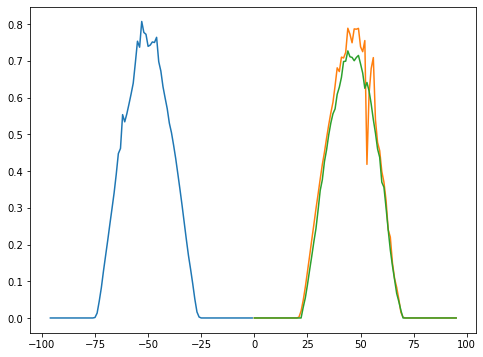

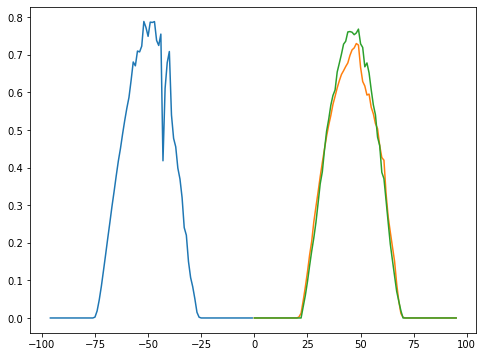

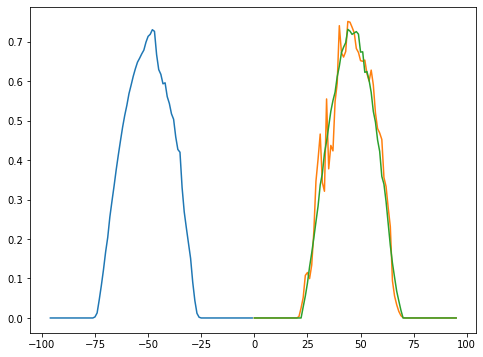

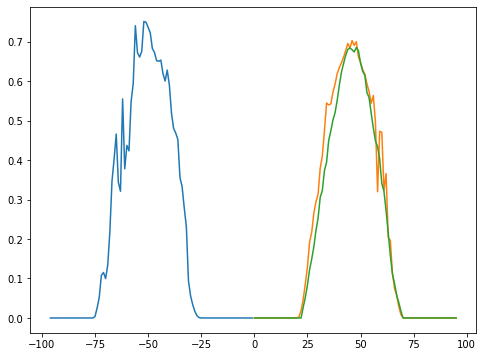

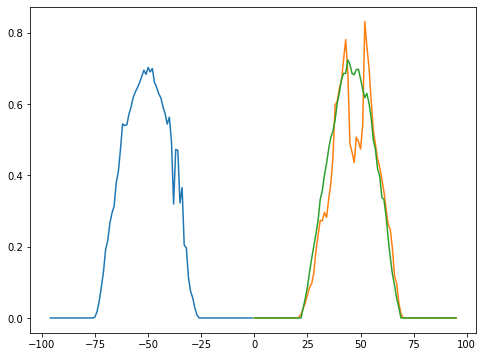

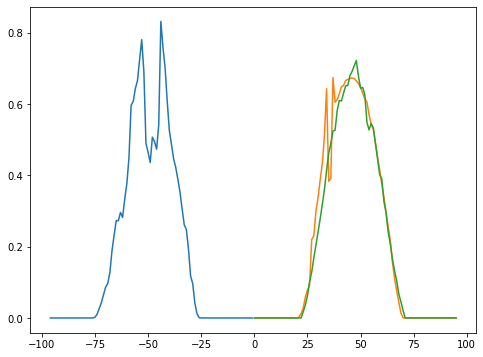

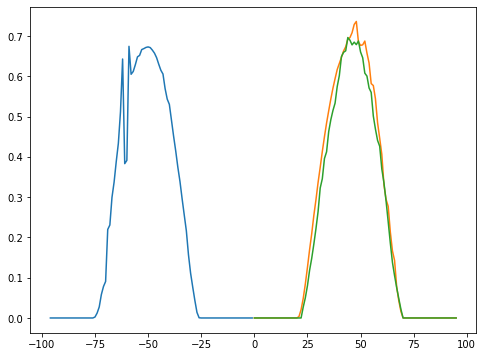

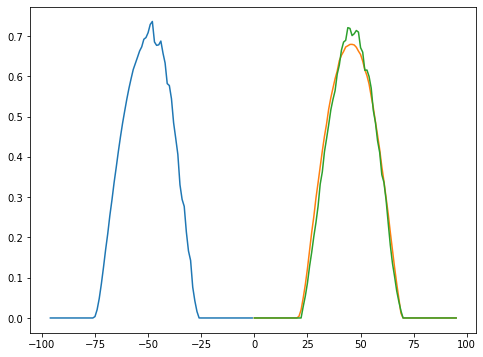

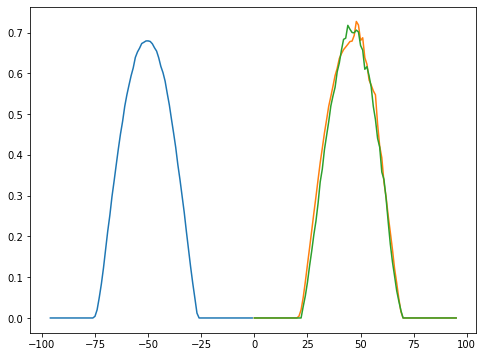

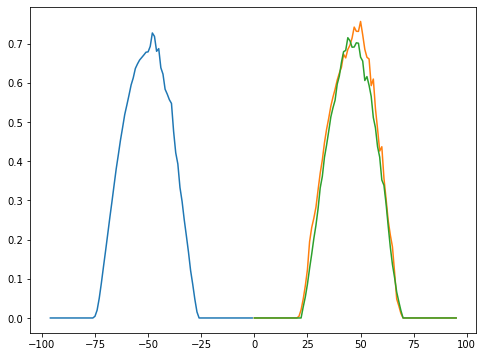

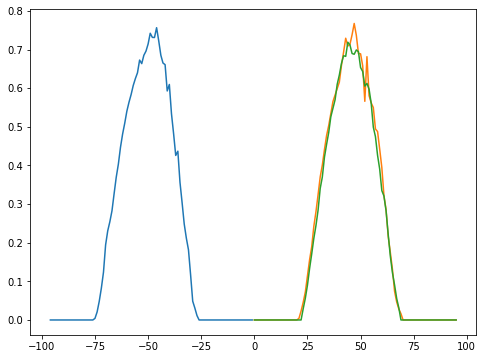

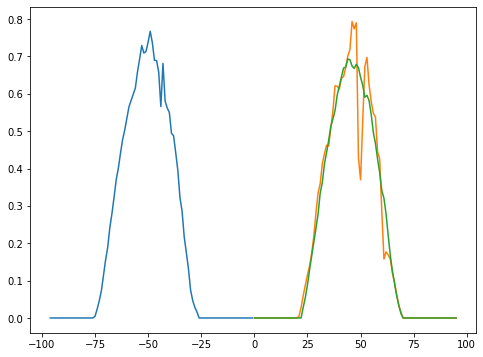

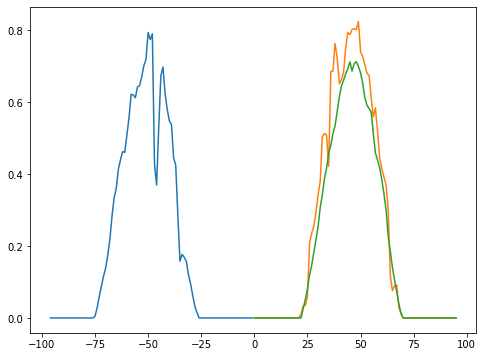

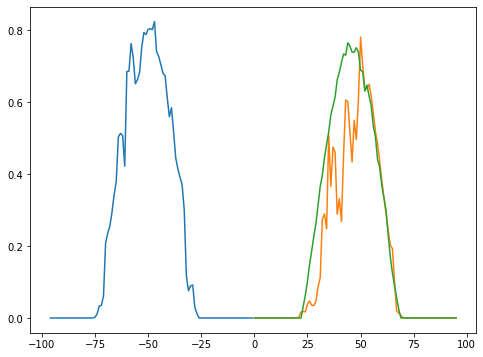

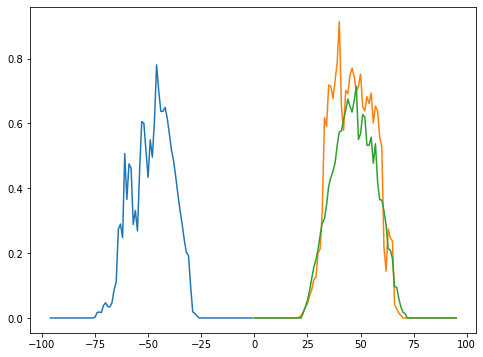

In [ ]:
for i in range(15):
  yh=tr.predict(x_val1)[i]
  yh[yh<0.01]=0
  yh[0:20]=0
  yh[75:]=0
  plt.figure()
  plt.plot(range(-96,0,1),(x_val1[i].reshape(96)),range(96),(y_val1[i].reshape(96)),range(96),yh)


---


# 7. **RESULTADOS** 📃


---


En esta sección del codigo se observarán y analizarán los resultados obtenidos realizando predicciones con el modelo que generamos.  ✌

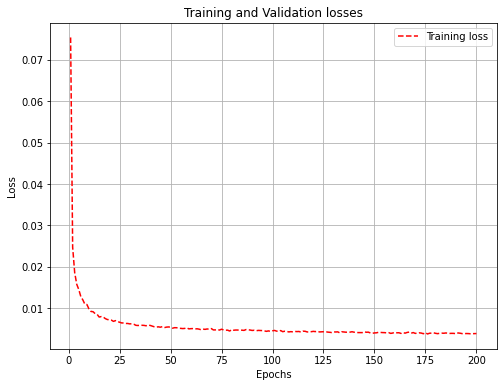

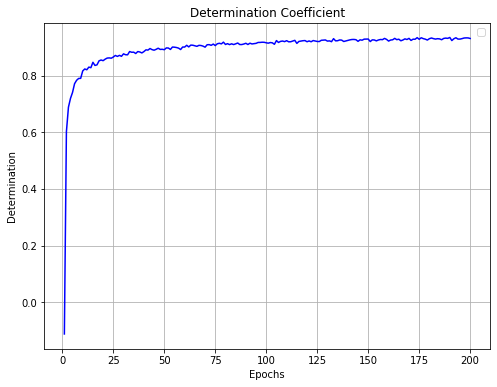

<Figure size 576x432 with 0 Axes>

In [ ]:
def metricas(history):
  loss     = tr.history['loss']
  val_loss = tr.history['mae' ]
  cod = tr.history['coeff_determination' ]


  epochs   = range(1,len(loss)+1,1)
  plt.plot ( epochs,     loss, 'r--', label='Training loss' )
  #plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.title ('Training and Validation losses'   )
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.grid(True)

  plt.legend()
  plt.figure() 

  plt.plot ( epochs, cod ,  'b' )
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.title ('Determination Coefficient')
  plt.ylabel('Determination')
  plt.xlabel('Epochs')
  plt.grid(True)

  plt.legend()
  plt.figure() 
metricas(tr)

**EVALUACIÓN DEL MODELO**

In [ ]:
tr.evaluate(x_val1, y_val1),tr.evaluate(x_train1, y_train1)

10/10 [==============================] - 1s 130ms/step - loss: 0.0033 - rmse: 0.0571 - mae: 0.0274 - smape: 54.3653 - coeff_determination: 0.9532


((0.9481417536735535,
  0.060690462589263916,
  0.028720982372760773,
  54.58024978637695),
 (0.9532179832458496,
  0.057051677256822586,
  0.02740744687616825,
  54.365272521972656))

**CÁLCULO DE LAS MÉTRICAS DE ERROR**

In [ ]:
n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_train1)):
  xt= x_train1[n][0]
  yt= y_train1[n]
  y=tr.predict(np.array([x_train1[n]]))[0]
  y[y<0.01]=0
  y[0:20]=0
  xt= scaler.inverse_transform(xt.reshape(-1, 1))
  yt= scaler.inverse_transform(yt) 
  y=scaler.inverse_transform(y.reshape(-1, 1))
  mape = np.divide(abs(yt-y), yt, out=np.zeros_like(abs(yt-y)), where=abs(yt)>=1).mean()
  mae = mean_absolute_error(yt,y)
  rmse = mean_squared_error(yt,y)**0.5

  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
tMAPE =np.array(MAPE).mean()
tMAE =np.array(MAE).mean()
tRMSE =np.array(RMSE).mean()

n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_val1)):
  xt= x_val1[n][0]
  yt= y_val1[n]
  y=tr.predict(np.array([x_val1[n]]))[0]
  y[y<0.01]=0
  y[0:20]=0
  xt= scaler.inverse_transform(xt.reshape(-1, 1))
  yt= scaler.inverse_transform(yt) 
  y=scaler.inverse_transform(y.reshape(-1, 1))
  mape = np.divide(abs(yt-y), yt, out=np.zeros_like(abs(yt-y)), where=abs(yt)>=1).mean()
  mae = mean_absolute_error(yt,y)
  rmse = mean_squared_error(yt,y)**0.5

  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
  
vMAPE =np.array(MAPE).mean()
vMAE =np.array(MAE).mean()
vRMSE =np.array(RMSE).mean()

In [ ]:
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(tMAE,tMAPE,tRMSE))
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(vMAE,vMAPE,vRMSE))
print("----------------------------------")


----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  42.2911      0.1741     78.6762
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  44.2590      0.1542     81.4436
----------------------------------


**Se aumenta el tamaño del lote, además se aumentan la cantidad de bloques de atención**

        self.head_size=256
        self.num_heads=48
        self.ff_dim=48
        self.num_transformer_blocks=20 # Número de bloques de redes neuronales
        self.mlp_units=[96] # Número de neuronas por cada red neuronal
        self.mlp_dropout=0.2 # Dropout de cada neurona
        self.dropout=0.2 # Dropout para el modelo completo

----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  41.2425      0.1823     79.0406
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  41.1399      0.1527     77.5041
----------------------------------

**15 bloques 180 unidades**

----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  40.8385      0.1775     77.0390
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  43.5356      0.1619     80.8355
----------------------------------

**20 Bloques, 180 unidades**

----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  42.6101      0.1772     79.2127
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  44.4644      0.1502     81.4923
----------------------------------

**15 Bloques, 180 Unidades**

----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  40.0051      0.1696     76.1290
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  40.3124      0.1464     76.0219
----------------------------------

**10 BLOQUES**

----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  42.4123      0.1907     79.7709
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  42.9293      0.1616     79.2954
----------------------------------

----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  56.9620      1.8281     94.1753
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  46.2038      0.5587     82.1798
----------------------------------

**GRÁFICOS CON LOS DATOS DE ENTRENAMIENTO**

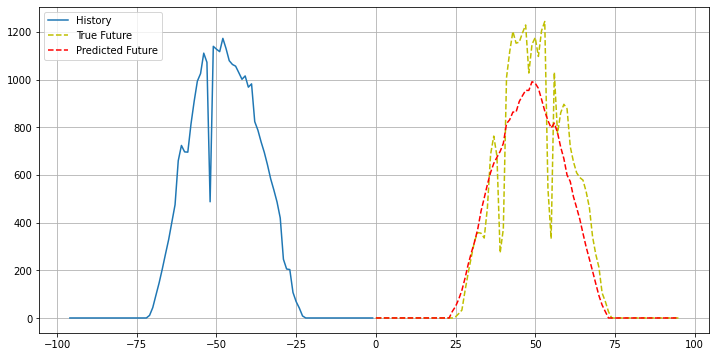

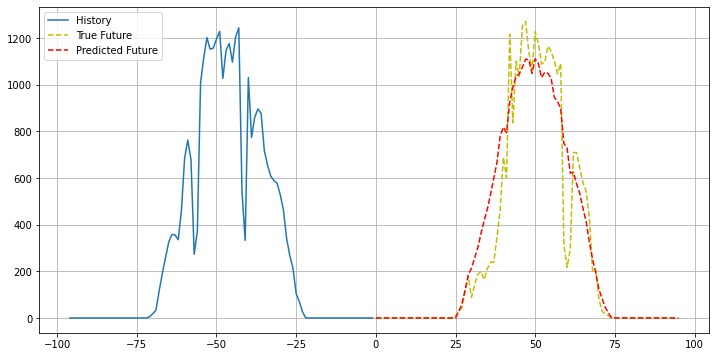

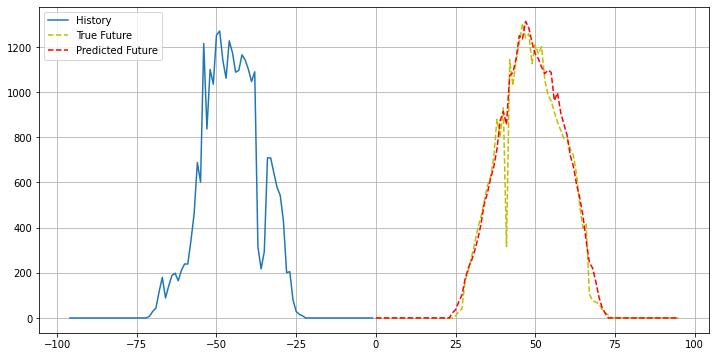

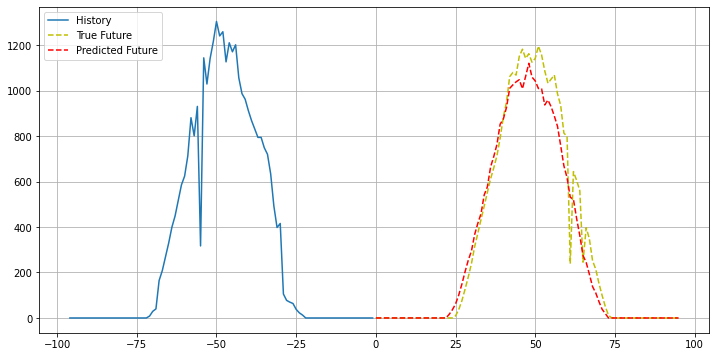

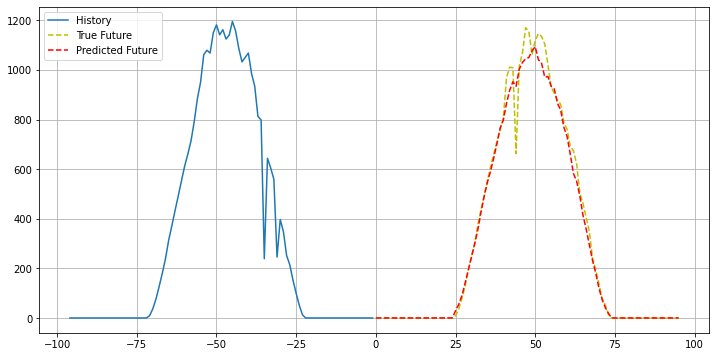

In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_train1[n]
  yt= y_train1[n]
  y=tr.predict(np.array([x_train1[n]]))[0]
  y[y<0.01]=0
  y[0:20]=0
  xt= scaler.inverse_transform(xt.reshape(-1, 1))
  yt= scaler.inverse_transform(yt) 
  y=scaler.inverse_transform(y.reshape(-1, 1))


  multi_step_plot(xt, yt, y)
  n+=1

**GRÁFICOS CON LOS DATOS DE VALIDACIÓN**

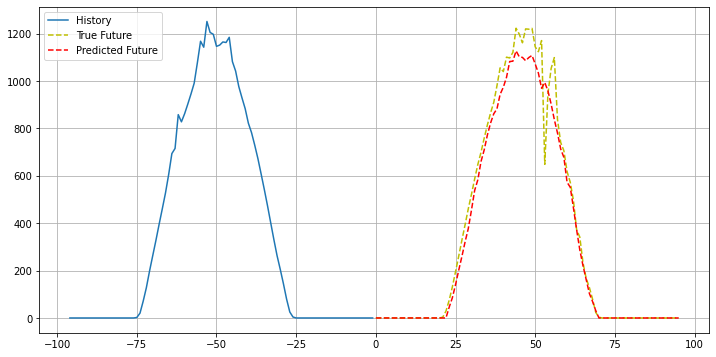

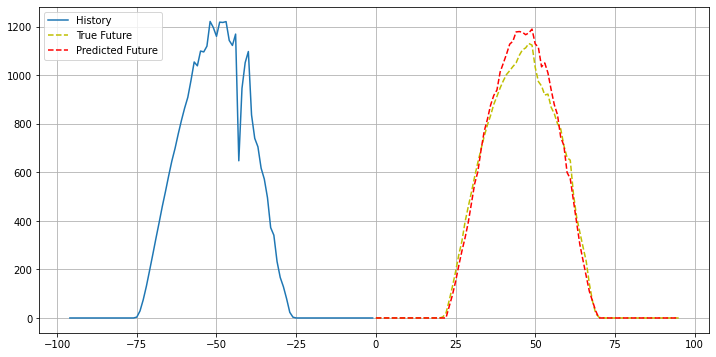

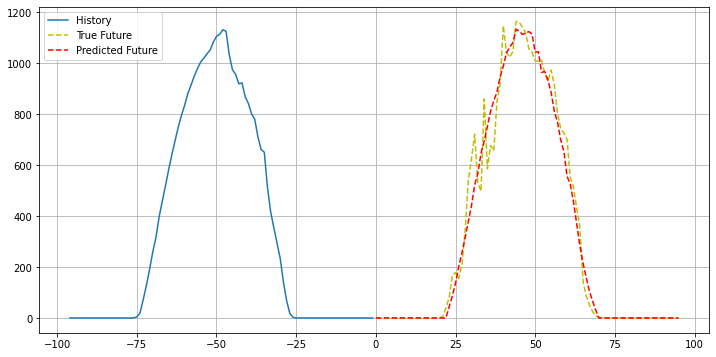

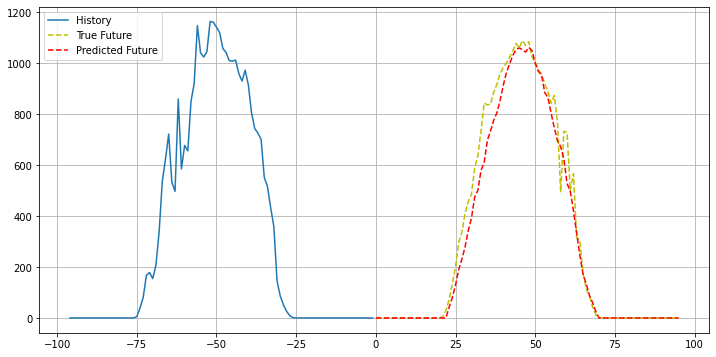

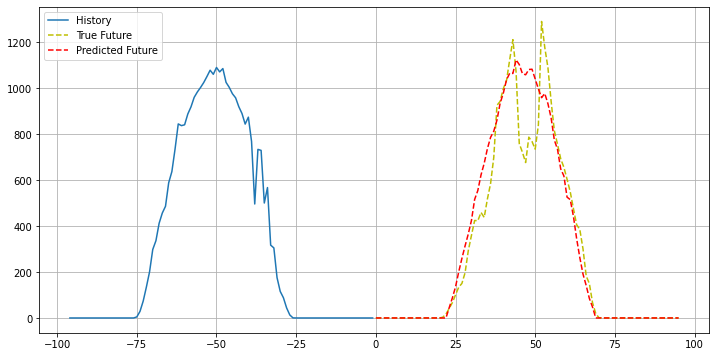

In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_val1[n]
  yt= y_val1[n]
  y=tr.predict(np.array([x_val1[n]]))[0]
  y[y<0.01]=0
  y[0:20]=0
  xt= scaler.inverse_transform(xt.reshape(-1, 1))
  yt= scaler.inverse_transform(yt) 
  y=scaler.inverse_transform(y.reshape(-1, 1))


  multi_step_plot(xt, yt, y)
  n+=1